<a href="https://colab.research.google.com/github/duy0699cat/AK/blob/main/Copy_of_Arknights_Stage_%2B_RIIC_Planner_v2_20.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Planner Manual

<b>TL;DR</b> This planner helps you optimize your RIIC-based production (factories and trading posts) in addition to the standard "which stages do I run?".

Click the arrow on the left to minimize the manual and go straight to the planner itself.

## Introduction

Greetings doctor!

I'm sure by now you've probably seen your fair share of farming planners for Arknights, and possibly used their analysis to help you decide which stages are most efficient to farm for you. At its core, this planner is much the same; it uses the same linear-programming techniques to figure out (i) which stages to farm and (ii) how much sanity each material is worth. The main advancement in this planner that it <em>factors in your RIIC</em>, which is responsible for a large part of your LMD/exp production. If you've ever been curious about what type of base to run (2 trading posts and 4 factories, or 3 trading posts and 3 factories?), what you should be boosting with your drones (trading posts or factories?), or even how to assign a sanity value to pure gold, then I hope this planner will be useful to you.

In the making of this planner, I have tried my best to account for a variety of game mechanics related to the way you earn materials. As a result, this planner has a long list of fields meant to better capture your unique situation. I understand that it is a hassle to compute these values and fill them in, so this planner comes with default values that I recommend sticking with initially. There are game mechanics that this planner does not currently capture, sometimes due to modeling difficulty (e.g. the recruitment permit <-> green certs cycle), sometimes due to lack of good data (e.g. how the friend credits shop stocks items), sometimes both. I look forward to future work that addresses these concerns!

Cheers,  
Luzark

## How to Use This Planner

0. You can make a personal copy of this planner via (File -> Save a Copy in Drive). This can be helpful if you want to keep around your field data or code changes, since you won't be able to save changes to the original read-only version. You might want to occasionally check the original for version updates, though!
1. You can interact with the planner by reading about the various input fields and changing them to better fit your personal Arknights situation. I recommend that basic users of the planner stick to filling out fields and avoid touching the underlying code. If you're unsure of the meaning of a field, you should stick to the suggested default value.
2. After you fill out all of the values, go to (Runtime -> Run all). Once all the cells finish running, you can scroll down to the bottom of this planner to examine the results. This step should take under a minute.
3. If something goes wrong, see the FAQ / Troubleshooting section. If that doesn't solve it, drop me a message on Discord.

## FAQ / Troubleshooting

- *The planner's taking a long time to run! Why's it so slow?*<br>
The sheet should run easily in under in under a minute, but sometimes there can be temporary issues allocating a Google machine.

- *Your planner thinks that battle records / pure gold / LMD / factory / trading post / power plant are worth zero sanity, and it is also running all sorts of crazy RIIC configurations. What gives?*<br>
Your material demand has (relatively) low demand for battle records and LMD, so the base finishes producing those long before you can farm the remaining materials with sanity. Since base efficiency doesn't matter for your input, the base is free to inefficiently swap bewteen many layouts. Try increasing demand for battle records and LMD, or increasing the sanity you have available each day to keep your base busy.

- *How can I tell whether the drones are being used to speed up pure gold or tactical battle records?*<br>
Power plant drones, when used on the factory, are converted to pure factory production at a rate of (1 day unboosted power plant) to (0.5 day unboosted factory). Check what the factories are producing to determine what you should be boosting.

- *Your planner gave something an efficiency rating of nan%, there's a bug!*<br>
If the planner detects that the inputs to an activity are worth zero sanity
(for example, you have too much base production and both factories and battle records become worthless), then it returns nan for the result of zero-value output divided by zero-value input.

## Planner Comparison

Here are my notes on different Arknights planners to help you decide which one fits your use case. I am aware of the following planners and will abbreviate them as follows:
- [`LUZ`](https://colab.research.google.com/drive/11NvYlUdAmTAUGpkYWEdSF_j2GfkQgS25?usp=sharing): This planner.
- [`AP`](https://penguin-stats.io/planner): Arkplanner, written by 🦀 and 根派. The backend engine for [ArkOneGraph](arkonegraph.herokuapp.com).
- [`GP`](https://gamepress.gg/arknights/tools/arknights-operator-planner-beta): Gamepress' planner, managed by EmmaNielson, Alyeska, and NorseFTX.
- [`MN`](https://www.reddit.com/r/arknights/comments/i0y1x8/arknights_priority_planner_update_4_now_with/): Written by [u/MathigNihilcehk](https://www.reddit.com/user/MathigNihilcehk/).
- [`MOE`](https://docs.google.com/spreadsheets/d/12X0uBQaN7MuuMWWDTiUjIni_MOP015GnulggmBJgBaQ/edit): Written by [u/elmoe0715](https://www.reddit.com/user/elmoe0715).

Obviously, the table entries below are based on my limited interactions with these planners. If unsure, I've annotated the entry with a question mark. If you have a correction to this table, please feel free to reach out to me (see Contact Info section). This table was written on August 5th, 2020, and is therefore unaware of planner updates since then.

| **Planner** | `LUZ` | `AP` | `GP` | `MN` | `MOE` |
| :-: | :-: | :-: | :-: | :-: | :-: |
| **User Interface** | Google Colab | Website | Website | Microsoft Excel | Google Sheets |
| **Objective Function** | Demand Vector | Demand Vector | Demand Vector | Demand Vector | Supply-Side |
| **Workshop Recipes** | Elite + Chips | Elite | Elite T4/T5 + Chips | Elite | Elite |
| **Workshop Byproducts** | Weighted Byproducts | Yes? | No Byproducts | Yes? | Weighted Byproducts |
| **Skill Summaries** | Yes | No | Yes | Yes | No |
| **Pure Gold Valuation** | Via LP Constraints | Via High Demand | No | No | Via Supply-Side Objective |



## Discussion of Techniques

### Problem Statement

The primary goal of planners is to solve the following problem:
> **Key Problem.** What's the fastest way to farm this set of materials?

The typical output of such a planner is the number of times to run each stage; let us refer to this as a "farming plan". A valid farming plan is one that produces the requested set of materials, and the optimal farming plan is the one that uses the least sanity among all valid farming plans.

Of course, there is randomness in what a stage will drop from run to run. For simplicity, we (and other planners) use the expected drop assumption:
> **Expected Drop Assumption.** Stages deterministically drop their expected materials. For example, PR-A-1 drops half of a defense chip, half of a medic chip, and 216 LMD.

This obviously is not true, but it greatly simplifies the math. Without this assumption, the optimal farming plan would be *adaptive*; based on what dropped from a stage, you would determine which stage to farm next.

### Linear Programming 101

Fortunately, our problem fits quite cleanly into the [Linear Programming](https://en.wikipedia.org/wiki/Linear_programming) (LP) framework. The gist of LP theory is that if your optimization problem can be written as a linear objective subject to linear constraints, then it can be efficiently solved. We can confirm that our key problem meets these requirements:
- Our problem variables are, for each stage, the number of times to farm that stage.
- Our problem objective is to spend the minimum amount of sanity. The amount of sanity spent is just (sanity cost of 0-1) x (times we run 0-1) + (sanity cost of 0-2) x (times we run 0-2) + ... This objective is indeed linear in our problem variables.
- Our constraints are that our farming plan must be valid. Let's concentrate on a single material we care about, e.g. LMD. If our farming plan is valid, then (LMD reward of 0-1) x (times we run 0-1) + (LMD reward of 0-2) x (times we run 0-2) + ... >= our LMD goal. This inequality is also linear in our program variables. In fact, we can write down one such inequality for every other material that we care about. If we satisfy all these linear inequalities, then our farming plan is valid.
- As a minor detail, we can't farm stages a negative number of times, so we also need to assert that (times we run 0-1) >= 0, etc. These are also linear inequalities.

Since our problem can be formulated as an LP, it means we can find the optimal farming plan by using an LP solver. However, there's a tiny catch: the number of times we are told to farm each stage might be fractional:

> **Fractional Farming Assumption.** The planner is allowed to run a stage a fractional amount. For example, running CE-5 half a time produces 3750 LMD at the cost of 15 sanity.

Some solvers might avoid this assumption by using a Mixed-Integer Program (MIP) instead, which allow you to ban fractional variable values. Unfortunately, MIPs are [harder to solve](https://en.wikipedia.org/wiki/NP-completeness), so we'll stick to LPs here for efficiency reasons.

### LP Duality and Material Sanity Values

At this point, some of you might be wondering how planners produce sanity values for materials, and what these values mean. It turns out that the theory of LPs informs us that every LP formulation has a [dual LP](https://en.wikipedia.org/wiki/Dual_linear_program) that we can work out by following a bunch of rules that convert our LP to its dual LP (it's called a dual because if we apply the rules again, we wind up with our original LP). There are a number of properties connecting these two linear programs, which we will discuss in this section.

In our case, when we apply the rules to transform our "primal" LP above into its dual, we get the following optimization problem:
- Our problem variables are for each material, its sanity value.
- Our objective is to maximize (demand for diketon) x (sanity value of diketon) + (demand for ester) x (sanity value of ester) + ...
- Our constraints are that, for each stage, the sanity values of the resulting materials cannot exceed the sanity cost of the stage.
- As a minor detail, the sanity value of a material cannot be negative.

In short, sanity values are derived by solving the dual LP problem above (remember, solving LPs is very efficient). The dual LP is deeply connected to the original LP; here's a list of well-known properties and how they translate to our setting when we solve for the optimal farming plan and optimal sanity values:
- **Strong Duality.** The sanity cost of our farming plan is equal to the sanity value of the demanded materials.
- **Complementary Slackness.** The optimal farming plan only uses stages that don't lose any sanity value. A material can only have zero sanity value if the optimal farming plan produces strictly too much of it.

### New Origin Resource: the Day

In our explanation so far, sanity is the resource from which all other resources are derived. Unfortunately, there's not really a direct relationship between sanity and RIIC productivity (ignoring that it can be inefficiently converted into drones). As a result, it's difficult for us to incorporate the RIIC when talking about minimizing sanity usage, since the RIIC doesn't consume sanity normally.

To get around this, the origin resource in this planner is actually the day. Previously, sanity got converted into materials via farming stages. The process is a little more complex now. Days get converted into sanity, factories, and trading posts. Sanity is still converted into materials. Factories are converted into pure gold and battle records. Trading posts and pure gold are converted into LMD.

When we use the above idea to rewrite our LP, several things change. Rather than minimizing sanity spent by the farming plan, we are now minimizing the number of days spent by the farming plan. When we take the dual LP, we actually get material day values rather than material sanity values. However, the fundamental principles remain the same. To make the results of this planner easier to compare against other planners, I have converted the material day values into material sanity values by dividing through by the day-value of one sanity.

### The RIIC

Perhaps the most straightforward way to factor in the RIIC is to note how much yours produces each day in LMD/battle records and treat that as a daily income (indeed, this is the approach taken by the `MN` planner). However, this approach does not let our LP solver freely swap between gold factories, exp factories, and trading posts.

Our approach is to introduce two psuedomaterials: the factory-day and the trading-post-day. The former represents the production of an unboosted factory over one day, while the latter represents the production of an unboosted trading post over one day. Each day, our RIIC could be in one of several configurations. For example, if you are running a 243 (2 trading posts, 4 factories, 3 power plants) base, then it's possible to convert to a 153 or a 333 base.

Without factoring operator bonuses, then, we have several ways to use up one day. For simplicity, let's assume that we receive 240 sanity per day.
- We could convert one farming day into 240 sanity, 1 trading-post-days, and 5 factory-days.
- We could convert one farming day into 240 sanity, 3 trading-post-days, and 3-factory-days.
- We could convert one farming day into 240 sanity, 2 trading-post-days, and 4 factory-days.

As you can see, this lets us exchange trading posts with factories. As a result, when we get a pure gold as a drop for a stage, we could spend some trading post time on converting it to LMD, but the opportunity cost is that we could have made factory time instead and printed battle records (or pure gold).

This planner does the above tradeoff, but also factors in operator bonuses and power plants. In particular, the first factory in your base has much better productivity than the fifth factory because your first factory gets its pick of your best operators while the fifth factory is scraping the bottom of the barrel.

## Credits and Contact Information

All names mentioned in this section are Discord usernames.

I've had many helpful conversations regarding planners with 🍑Moe🍑#2568, who authored the `MOE` planner. Moe has also helped me beta test this planner.

Many of the features/bugfixes (see Version History) were requested by ScifiGemini0616#3863 or neia#6681, so I'd like to thank them for using the planner and giving great feedback.

I've also had the pleasure of working with samidare ☔#5449, who has helpfully provided a JSON of operator material needs so that I could compute some standard material demand vectors via code rather than manual data entry. Sami maintains an excellent [Arknights materials checklist website](https://samidare.io/arknights).

This work also would not have been possible without the aid of the #r-i-i-c club in the Arknights Official Discord Server, which has helped me with several RIIC-related calculations and default values. In particular (and in alphabetical order), I would like to thank Forge#2341, Lance#1186, ScifiGemini0616#3863, and Vinci#4580 for teaching me about RIIC mechanics, helping me generate reasonable default values for this planner, and beta testing this planner.

I'd also like to thank MySteRiouS#0972 for helping me with the monthly log-in mechanics when I was querying #help.

Thanks to Penguin Statistics for collecting invaluable drop data without which this project would not be possible. This project inherits a [CC BY-NC 4.0](https://creativecommons.org/licenses/by-nc/4.0/) license from this data.

Thanks to Gamepress for event, operator, and other miscellaneous information.

If you spot a bug or have other feedback, please feel free to contact me as Luzark#8152 on Discord.

## Version History

Version 2.20 (October 3, 2021)
- Added Chapter 9 stages and materials (solvent and cutting T3, T4s), including adjusting the byproduct weights.
- Added events up to Maria Nearl retrospection.
- Added permanent event stages up to Under Tides and Gavial the Great Chief Returns.
- Renamed Crystalline Electroassembly to Crystalline Electronic Unit to match the English translation.

Version 2.19 (July 2, 2021)
- Changed annihilation 3 language to be general annihilation (thanks for the bug report ScifiGemini0616#3863).
- Added comment about Purestream, Conviction, and Beanstalk (thanks for the bug report ScifiGemini0616#3863).

Version 2.18 (May 1, 2021)
- Stages are now keyed by stage id rather than stage name. This allows for the planner to reason about stages with the same name (e.g. original event versus retrospection, or Children of Ursus versus Under Tides). Thanks to neia#6681 for bringing the Under Tides issue to my attention. Planner should generally break less when new CN stages come out.
- Added new CN events and retrospection events to the list of event choices.

Version 2.17 (April 30, 2021)
- Added option for increased crystal demand so that crystal can't be satisfied just via byproducts (pegged to alloy suggested by neia#6681).

Version 2.16 (April 30, 2021)
- Fixed omission of stages JT8-1 through JT8-3 due to parsing error (thanks for the efficient stage comparison 🍑Moe🍑#2568 and neia#6681)

Version 2.15 (April 30, 2021)
- Fixed S7-2's LMD drop to 1216 LMD (thanks neia#6681).
- Changed the default story setting to chapter 8.
- Updated the names of the crystal materials with official translations (thanks for the pointer samidare ☔#5449).

Version 2.14 (April 21, 2021)
- Fixed new bug regarding rerun stages now having _perm suffix instead of _rep (thanks for the bug report neia#6681).

Version 2.13 (April 11, 2021)
- Fixed bug regarding Rewinding Breeze through Operation Originium Dust event stages (thanks for the bug report Jiramide#7358).

Version 2.12 (April 10, 2021)
- Fixed bug regarding custom material demand vectors (thanks for the bug report ScifiGemini0616#3863).

Version 2.11 (April 5, 2021)
- Added better fix for reruns having a different id in PenguinStats (thanks for the bug report regarding DM rerun, ScifiGemini0616#3863).
- Added checkboxes for Rewinding Breeze, Maria Nearl, Mansfield Break, Beyond Here, Who Is Real, and Operation Originium Dust.

Version 2.10 (January 27, 2021)
- Added skip condition for Amiya (Guard) material demand (thanks ScifiGemini0616#3863).

Version 2.9 (January 6, 2021)
- Fixed minor typo (yoru -> your) in the introduction (thanks ScifiGemini0616#3863).
- Updated the #r-i-i-c default numbers to account for THRM-EX and properly exclude Swire, calculated by ScifiGemini0616#3863.
- Planner now no longer informs you that Sanity is worth 1.0 Sanity, requested by neia#6681.
- Added toggle for buying out T1 green cert shop, requested by ScifiGemini0616#3863.
- Implemented demand vector based on Elite 2, Level 90, and a random Mastery 3, requested by Forge#2341. It is the new planner default, since it gives a realistic evaluation of the skill book distribution needed while still maintaining that exp/LMD have some value.
- Updated the default skill summary byproduct number to Matoimaru's 70% bonus (noted by Vinci#4580).

Version 2.8 (December 30, 2020)
- Added option to exclude a single stage from the planner (requested by neia#6681).
- Added chapter 8 materials, stages, and workshop recipes. Swapped the chapter selector from a checkbox to a dropdown.
- Swapped from outdated hand-entered standard material demands to ones generated from samidare ☔#5449's operator info JSON.

Version 2.7 (December 1, 2020)
- Fixed logic to handle PenguinStats stages, since Code of Brawl rerun stages just got added (thanks for the bug report, neia#6681).

Version 2.6 (November 15, 2020)
- Added experimental stage-output visualizer.

Version 2.5 (November 1, 2020)
- Added logic to ignore PenguinStats' new, currently low-quality chip drop data (thanks ScifiGemini0616#3863 for reporting).

Version 2.4 (October 11, 2020)
- Make material demand fields can now adjust presets rather than only applying to CUSTOM (requested by Aya#0847).

Version 2.3 (October 1, 2020)
- Fixed error when loading PenguinStats stages, since repeated event involves duplicated stages (GT-1 is both 'a001_01' and 'a001_02_rep').

Version 2.2 (September 30, 2020)
- Fixed efficiency bug when dividing by really small sanity-value input (thanks ScifiGemini0616#3863 for reporting!)

Version 2.1 (September 30, 2020)
- Added toggle for weekly annihilation 3 runs, which deducts sanity while also yielding LMD and frontline battle records (thanks ScifiGemini0616#3863 for drops reminder).

Version 2.0 (September 28, 2020)
- Added PenguinStats interface, along with the option to include event stages up to Gavial the Great Chief Returns. This replaces the need to read data from Moe's planner, so the user no longer needs to authenticate to Google.

Version 1.4 (August 26, 2020)
- Made the code more modular.
- Added more descriptive activity names.
- Cleaned up manual slightly.

Version 1.3 (August 16, 2020)
- Updated trading post order size multipliers, thanks cube#1588.
- Added more section headers, suggested by ScifiGemini0616#3863.

Version 1.2 (August 10, 2020)
- Fixed a typo, thanks july#7561.

Version 1.1 (August 8, 2020)
- Fixed polyester lump workshop formula, thanks Mindrak#9074.

Version 1.0 (August 8, 2020)
- Minor precision cleanup to three digits.
- Official launch.

Version 0.8 (August 7, 2020)
- Stripped out dummy activities (6-6, 6-7, 6-13, 6-17) from output.
- Implemented efficiency scores for all activities (output value / input value).

Version 0.7 (August 5, 2020)
- Wrote Planner Comparison and Discussion of Techniques sections.
- Divided cells into Manual / Planner sections.

Version 0.6 (August 4, 2020)
- Implemented default demand vectors.
- Added additional custom demand vector material choices.
- Started a FAQ section.

Version 0.5 (August 2, 2020)
- Implemented Daily Missions, Weekly Missions, Monthly Sign-In

Version 0.4 (August 1, 2020)
- Implemented power plants / droning

Version 0.3 (July 31, 2020)
- Fixed a bug causing factory to produce too much exp - thanks Lance#1186.

Version 0.2 (July 31, 2020)
- Implemented skill summary farming.
- Implemented chip farming (chips & red certs).

Version 0.1 (July 30, 2020)
- Fixed bug peventing input of material demand vector - thanks ScifiGemini0616#3863.
- Marked unimplemented workshop formulas.

Version 0.0 (July 30, 2020)
- Beta version of planner released.

## Future TODOs (No Promises!)

Version 2.X
- Add better stage exclusion options that don't require penguinstats lookups.
- Integrate fancier output code from veriens#3193.
- Debug VisibleDeprecationError, I think it occurs due to the scipy.optimize.linprog() call though...
- Add event token -> LMD conversions, requested by neia#6681.
- Add furniture calculations, maybe neia#6681 / GL1TCH3D#1337 care.
- Implement green cert shop, recruitment permits, headhunting cycle, possibly via a psuedomaterial for six stars.
- Implement friend credits calculation (low priority) based on PeterYR's data. 

# Supporting Code

In [ ]:
# @title Basic Imports for Matrices & Linear Programs

import numpy as np
import scipy.optimize

In [ ]:
# @title Special Hardcoded Data

# Map from material to material group name. This one serves as a whitelist of
# materials to use from PenguinStats' list; I don't like their group choices
# so we're going with this Luzark-curated list.
material_name_to_group = {
  'Drill Battle Record': 'Battle Record',
  'Frontline Battle Record': 'Battle Record',
  'Tactical Battle Record': 'Battle Record',
  'Strategic Battle Record': 'Battle Record',
  'Pure Gold': 'Currency',
  'Orirock': 'Orirock',
  'Orirock Cube': 'Orirock',
  'Orirock Cluster': 'Orirock',
  'Orirock Concentration': 'Orirock',
  'Damaged Device': 'Device',
  'Device': 'Device',
  'Integrated Device': 'Device',
  'Optimized Device': 'Device',
  'Ester': 'Ester',
  'Polyester': 'Ester',
  'Polyester Pack': 'Ester',
  'Polyester Lump': 'Ester',
  'Sugar Substitute': 'Sugar',
  'Sugar': 'Sugar',
  'Sugar Pack': 'Sugar',
  'Sugar Lump': 'Sugar',
  'Oriron Shard': 'Oriron',
  'Oriron': 'Oriron',
  'Oriron Cluster': 'Oriron',
  'Oriron Block': 'Oriron',
  'Diketon': 'Keton',
  'Polyketon': 'Keton',
  'Aketon': 'Keton',
  'Keton Colloid': 'Keton',
  'Loxic Kohl': 'Kohl',
  'White Horse Kohl': 'Kohl',
  'Manganese Ore': 'Manganese',
  'Manganese Trihydrate': 'Manganese',
  'Grindstone': 'Grindstone',
  'Grindstone Pentahydrate': 'Grindstone',
  'Crystalline Component': 'Crystal',
  'Crystalline Circuit': 'Crystal',
  'RMA70-12': 'RMA',
  'RMA70-24': 'RMA',
  'Carbon Stick': 'Carbon',
  'Carbon Brick': 'Carbon',
  'Carbon Pack': 'Carbon',
  'Skill Summary - 1': 'Skill Summary',
  'Skill Summary - 2': 'Skill Summary',
  'Skill Summary - 3': 'Skill Summary',
  'Coagulating Gel': 'Gel',
  'Polymerized Gel': 'Gel',
  'Incandescent Alloy': 'Alloy',
  'Incandescent Alloy Block': 'Alloy',
  'Seminatural Solvent': 'Solvent',
  'Refined Solvent': 'Solvent',
  'Compound Cutting Fluid': 'Cutting',
  'Cutting Stock Solution': 'Cutting',
  'Polymerization Preparation': 'Tier Five',
  'Bipolar Nanoflake': 'Tier Five',
  'D32 Steel': 'Tier Five',
  'Crystalline Electronic Unit': 'Tier Five',
  'Vanguard Chip Pack': 'Chip',
  'Guard Chip Pack': 'Chip',
  'Defender Chip Pack': 'Chip',
  'Sniper Chip Pack': 'Chip',
  'Caster Chip Pack': 'Chip',
  'Medic Chip Pack': 'Chip',
  'Supporter Chip Pack': 'Chip',
  'Specialist Chip Pack': 'Chip',
  'Vanguard Chip': 'Chip',
  'Guard Chip': 'Chip',
  'Defender Chip': 'Chip',
  'Sniper Chip': 'Chip',
  'Caster Chip': 'Chip',
  'Medic Chip': 'Chip',
  'Supporter Chip': 'Chip',
  'Specialist Chip': 'Chip',
}

# Same as above, except these are non-PenguinStats materials that our planner
# considers (or psuedomaterials).
additional_material_name_to_group = {
  # Currencies
  'LMD': 'Currency',
  'Shop Voucher': 'Currency',
  # Chips
  'Vanguard Dualchip': 'Chip',
  'Guard Dualchip': 'Chip',
  'Defender Dualchip': 'Chip',
  'Sniper Dualchip': 'Chip',
  'Caster Dualchip': 'Chip',
  'Medic Dualchip': 'Chip',
  'Supporter Dualchip': 'Chip',
  'Specialist Dualchip': 'Chip',
  'Chip Catalyst': 'Chip',
  # Psuedo-materials. These aren't real materials, but our computation will
  # assign them a value just like every other material.
  'Sanity': 'Energy',
  'Factory': 'RIIC',  # represents one unboosted factory for one day
  'Trading Post': 'RIIC',  # represents one unboosted trading post for one day
  'Power Plant': 'RIIC',   # represents unboosted power plant for one day
}

# Mostly obtained by inspecting
# https://raw.githubusercontent.com/iansjk/arknights-tools/master/src/data/operators.json
# https://raw.githubusercontent.com/Dimbreath/ArknightsData/master/zh-CN/gamedata/excel/building_data.json
additional_material_name_to_id = {
  # Currencies
  'LMD': '4001',
  # Chips
  'Vanguard Dualchip': '3213',
  'Guard Dualchip': '3223',
  'Defender Dualchip': '3233',
  'Sniper Dualchip': '3243',
  'Caster Dualchip': '3253',
  'Medic Dualchip': '3263',
  'Supporter Dualchip': '3273',
  'Specialist Dualchip': '3283',
  'Chip Catalyst': '32001',
}

# Mapping from materials to colors, hand-picked by Luzark and used when plotting
# drop information.
material_name_to_color = {
    'Orirock': '#50412e',
    'Orirock Cube': '#7e7a50',
    'Orirock Cluster': '#b49b5f',
    'Orirock Concentration': '#e2c694',
    'Sugar Substitute': '#646363',
    'Sugar': '#a5cd2c',
    'Sugar Pack': '#13a0d2',
    'Sugar Lump': '#d9b219',
    'Ester': '#5d651a',
    'Polyester': '#7b942d',
    'Polyester Pack': '#a5cd2c',
    'Polyester Lump': '#d0e32e',
    'Oriron Shard': '#496065',
    'Oriron': '#466f91',
    'Oriron Cluster': '#7ccef0',
    'Oriron Block': '#8ae5fa',
    'Diketon': '#c35e28',
    'Polyketon': '#8d4f22',
    'Aketon': '#d9b219',
    'Keton Colloid': '#fbd70d',
    'Damaged Device': '#3e3f3b',
    'Device': '#8e2621',
    'Integrated Device': '#c3312c',
    'Optimized Device': '#e23933',
    'Loxic Kohl': '#ff6e14',
    'White Horse Kohl': '#c3312c',
    'Manganese Ore': '#9890aa',
    'Manganese Trihydrate': '#655b78',
    'Grindstone': '#d88d63',
    'Grindstone Pentahydrate': '#daacb0',
    'Crystalline Component': '#4b7a62',
    'Crystalline Circuit': '#80c4df',
    'RMA70-12': '#fdfad8',
    'RMA70-24': '#c3312c',
    'Incandescent Alloy': '#a09a7c',
    'Incandescent Alloy Block': '#eec00d',
    'Coagulating Gel': '#0da0ee',
    'Polymerized Gel': '#a1feff',
    'Polymerization Preparation': '#32add1',
    'Bipolar Nanoflake': '#e23933',
    'D32 Steel': '#c2e2ec',
    'Crystalline Electronic Unit': '#79c9df',
    'Skill Summary - 1': '#cbcecd',
    'Skill Summary - 2': '#6c7625',
    'Skill Summary - 3': '#0676a9',
    'Carbon Stick': '#494746',
    'Carbon Brick': '#927e60',
    'Carbon Pack': '#7b942d',
    'Pure Gold': '#e16e14',
    'LMD': '#a5d2e3',
    'Drill Battle Record': '#edfd28',
    'Frontline Battle Record': '#2ab9ed',
    'Tactical Battle Record': '#fbd70d',
    'Strategic Battle Record': '#f5dfc6',
    'Shop Voucher': '#f25b63',
    'Factory': '#ffff67',
    'Trading Post': '#33cbfe',
    'Power Plant': '#ccff66',
}

# Mapping from material groups to colors, hand-picked by Luzark and used when
# plotting drop information.
group_name_to_color = {
    'Battle Record': '#f5dfc6',
    'Currency': '#a5d2e3',
    'Orirock': '#b49b5f',
    'Device': '#e23933',
    'Ester': '#d0e32e',
    'Sugar': '#d8d8d7',
    'Oriron': '#8ae5fa',
    'Keton': '#fbd70d',
    'Kohl': '#c3312c',
    'Manganese': '#655b78',
    'Grindstone': '#daacb0',
    'RMA': '#c3312c',
    'Carbon': '#494746',
    'Skill Summary': '#aaabab',
    'Gel': '#a1feff',
    'Alloy': '#eec00d',
    'Crystal': '#4b7a62',
    'Tier Five': '#fee80e',
    'Chip': '#235d6d',
    'Energy': '#373737',
    'RIIC': '#ccff66',
}

# Map from a regex of stage id to the stage group it belongs in.
stage_regex_to_group = {
    'main_00-\d\d': 'Prologue: Evil Time Part 1',
    'main_01-\d\d': 'Episode 1: Evil Time Part 2',
    'main_02-\d\d': 'Episode 2: Separated Hearts',
    'sub_02-\d\d': 'Episode 2: Separated Hearts',
    'main_03-\d\d': 'Episode 3: Stinging Shock',
    'sub_03-\d-\d': 'Episode 3: Stinging Shock',
    'main_04-\d\d': 'Episode 4: Burning Run',
    'sub_04-\d-\d': 'Episode 4: Burning Run',
    'main_05-\d\d': 'Episode 5: Necessary Solutions',
    'sub_05-\d-\d': 'Episode 5: Necessary Solutions',
    'main_06-\d\d': 'Episode 6: Partial Necrosis',
    'sub_06-\d-\d': 'Episode 6: Partial Necrosis',
    'main_07-\d\d': 'Episode 7: The Birth of Tragedy',
    'sub_07-\d-\d': 'Episode 7: The Birth of Tragedy',
    'main_08-\d\d': 'Episode 8: Roaring Flare',
    'main_09-\d\d': 'Episode 9: Stormwatch',
    'sub_09-\d-\d': 'Episode 9: Stormwatch',
    'wk_kc_\d': 'Tactical Drill',
    'wk_toxic_\d': 'Tough Siege',
    'wk_fly_\d': 'Aerial Threat',
    'wk_armor_\d': 'Resource Search',
    'wk_melee_\d': 'Cargo Escort',
    'pro_a_\d': 'Solid Defense',
    'pro_b_\d': 'Fierce Attack',
    'pro_c_\d': 'Unstoppable Charge',
    'pro_d_\d': 'Fearless Protection',
    'a001_\d\d': 'Grani and the Knights\' Treasure',
    'a003_\d\d': 'Heart of Surging Flame',
    'a003_f\d\d': 'Heart of Surging Flame',
    'act4d0_\d\d': 'Operational Intelligence',
    'act5d0_\d\d': 'Code of Brawl',
    'act6d5_\d\d': 'Ancient Forge',
    'act7d5_\d\d': 'Stories of Afternoon',
    'act9d0_\d\d': 'Darknights Memoir',
    'act10d5_\d\d': 'Children of Ursus',
    'act11d0_\d\d': 'Twilight of Wolumonde',
    'act12d0_\d\d': 'Gavial the Great Chief Returns',
    'act13d0_\d\d': 'Rewinding Breeze',
    'act001_\d\d_rep': 'Grani and the Knights\' Treasure Retrospection',
    'act13d5_\d\d': 'Maria Nearl',
    # Line between EN and CN currently here as of last planner update.
    'act5d0_\d\d_rep': 'Code of Brawl Retrospection',
    'act15d0_\d\d': 'Mansfield Break',
    'act15d5_\d\d': 'Beyond Here',
    'act16d5_\d\d': 'Who is Real',
    'act17d0_\d\d': 'Operation Originium Dust',
    'act9d0_\d\d_rep': 'Darknights Memoir Retrospection',
    'act18d0_\d\d': 'A Walk in the Dust',
    # Line between EN and CN currently here as of last planner update.
    'act18d3_\d\d': 'Under Tides',
    'act7mini_\d\d': 'Preluding Lights',
    'act11d0_\d\d_rep': 'Twilight of Wolumonde Retrospection',
    'act8mini_\d\d': 'Vigilo',
    'act12d0_\d\d_rep': 'Gavial the Great Chief Returns Retrospection',
    'act12side_\d\d': 'Dossoles Holiday',
    'act13d5_\d\d_rep': 'Maria Nearl Retrospection',
    # Insert New Events Here
    'act9d0_\d\d_perm': 'Darknights Memoir (Permanent)',
    'act18d0_\d\d_perm': 'A Walk in the Dust (Permanent)',
    'act18d3_\d\d_perm': 'Under Tides (Permanent)',
    'a001_\d\d_perm': 'Grani and the Knights\' Treasure (Permanent)',
    'a003_f\d\d_perm': 'Heart of Surging Flame (Permanent)',
    'act11d0_\d\d_perm': 'Twilight of Wolumonde (Permanent)',
    'act12d0_\d\d_perm': 'Gavial the Great Chief Returns (Permanent)',
}

In [ ]:
# @title Basic Interfacing with Web Data
# @markdown Code which can grab information from PenguinStats API V2 and [Samidare☔#5449's Operator Info](https://raw.githubusercontent.com/iansjk/arknights-tools/master/src/data/operators.json).

import json
import requests

class WebAPI:
  @staticmethod
  def query(url, params=None):
    return json.loads(requests.get(url=url, params=params).text)

class PenguinStatsAPI(WebAPI):
  @staticmethod
  def items():
    return WebAPI.query(
        'https://penguin-stats.io/PenguinStats/api/v2/items')

  @staticmethod
  def matrix():
    return WebAPI.query(
        'https://penguin-stats.io/PenguinStats/api/v2/result/matrix',
        {'server': 'CN',
         'show_closed_zones': True})

  @staticmethod
  def stages(stage_id=None):
    return WebAPI.query(
        'https://penguin-stats.io/PenguinStats/api/v2/stages')
    
class SamidareGithubAPI:
  @staticmethod
  def operators():
    return WebAPI.query(
        'https://raw.githubusercontent.com/iansjk/arknights-tools/master/src/data/operators.json'
    )

In [ ]:
# @title Retrieving Materials from PenguinStats.

import functools

# @markdown Please select what main story episode to include up to. This choice affects the basic stages available to the planner, as well as what materials are considered (episode 8 introduces crystal materials).
# @markdown
# @markdown <img src="https://gamepress.gg/arknights/sites/arknights/files/inline-images/ArknightsBannerCNEpisode6PartialNecrosis.jpg" width="400">
# @markdown
# @markdown <img src="https://gamepress.gg/arknights/sites/arknights/files/inline-images/ArknightsBannerCNChapter7.jpg" width="400">
# @markdown
# @markdown <img src="https://gamepress.gg/arknights/sites/arknights/files/2020-11/Episode%208.jpeg" width="400">
# @markdown
# @markdown <img src="https://gamepress.gg/arknights/sites/arknights/files/2021-09/Episode9Stormwatch_0.jpeg" width="400">
highest_episode_to_include = '8'  #@param ['6', '7', '8', '9']
highest_episode_to_include = int(highest_episode_to_include)

@functools.total_ordering
class Material:
  """Represents either a classical Arknights or special planner material."""

  def __init__(self, name_i18n, item_id, group):
    self._name_i18n = name_i18n
    self._item_id = item_id
    self._group = group
    self._numpy_id = -1
  
  @property
  def name_i18n(self):
    return self._name_i18n

  @property
  def name(self):
    return self._name_i18n['en']

  @property
  def item_id(self):
    return self._item_id
  
  @property
  def group(self):
    return self._group

  @property
  def numpy_id(self):
    return self._numpy_id

  @numpy_id.setter
  def numpy_id(self, value):
    self._numpy_id = value

  def __hash__(self):
    return hash(self.name)

  def __eq__(self, other):
    return self.name == other.name

  def __lt__(self, other):
    return self.name < other.name

class MaterialCollection:
  """Collection of Material with convenience lookup functions."""

  def __init__(self):
    self._material_list = []         # [Material]
    self._name_to_material = {}      # {string: Material}
    self._item_id_to_material = {}   # {string: Material}
    self._numpy_id_to_material = {}  # {int: Material}
  
  def add_material(self, material):
    """Adds a material to the collection. Should have unique name and id.
    
    Args:
      material: Material being added.
    
    Throws:
      LookupError: material's name or item_id is nonunique.
    """
    if material.name in self._name_to_material:
      raise LookupError('Material name is nonunique: {}'.format(material.name))
    if material.item_id in self._item_id_to_material:
      raise LookupError('Material item id is nonunique: {}'.format(
          material.item_id))

    numpy_id = len(self._material_list)
    self._material_list.append(material)
    self._name_to_material[material.name] = material
    self._item_id_to_material[material.item_id] = material
    self._numpy_id_to_material[numpy_id] = material
    material.numpy_id = numpy_id

  def add_ignored_material(self, name, item_id):
    """Bans name/item_id from appearing in the collection as real materials.

    When looking up name/item_id in the future, None will be returned instead of
    a material.
    
    Args:
      name: string
      item_id: string
    
    Throws:
      LookupError: material's name or item_id is nonunique.
    """
    if name in self._name_to_material:
      raise LookupError('Ignored material name is nonunique: {}'.format(name))
    if item_id in self._item_id_to_material:
      raise LookupError('Ignored material item id is nonunique: {}'.format(
          item_id))
    
    self._name_to_material[name] = None
    self._item_id_to_material[item_id] = None

  def get_material_with_name(self, name):
    """Finds the material with the given name.
    
    Returns:
      Material or None (indicating an ignored material)
    """
    return self._name_to_material[name]

  def get_material_with_item_id(self, item_id):
    """Finds the material with the given item_id.
    
    Returns:
      Material or None (indicating an ignored material)
    """
    return self._item_id_to_material[item_id]
  
  def get_material_with_numpy_id(self, numpy_id):
    """Finds the material with the given numpy_id.
    
    Returns:
      Material
    """
    return self._numpy_id_to_material[numpy_id]

  def get_all_materials(self):
    """Generates all materials.
    
    Yields:
      Material
    """
    for material in self._material_list:
      yield material
  
  def num_materials(self):
    """The number of materials currently in the collection."""
    return len(self._material_list)

def get_penguin_stats_materials():
  """Fetches material list from penguin-stats with post-processing.

  Returns:
    MaterialCollection
  """
  ps_materials = PenguinStatsAPI.items()

  # Penguin Stats has a out-of-date translation, it thinks Carbon Pack is Carbon
  # Brick (i.e. it thinks 3113 and 3114 are both Carbon Brick).
  for ps_material in ps_materials:
    if ps_material['itemId'] == '3114':
      ps_material['name_i18n']['en'] = 'Carbon Pack'
    if ps_material['itemId'] == '30014':
      ps_material['name_i18n']['en'] = 'Orirock Concentration'

    if ps_material['itemId'] == '31033':
      # <https://gamepress.gg/arknights/item/crystal-element>
      ps_material['name_i18n']['en'] = 'Crystalline Component'
    if ps_material['itemId'] == '31034':
      # <https://gamepress.gg/arknights/item/crystal-circuit>
      ps_material['name_i18n']['en'] = 'Crystalline Circuit'
    if ps_material['itemId'] == '30145':
      # <https://gamepress.gg/arknights/item/crystal-electronic-unit>
      ps_material['name_i18n']['en'] = 'Crystalline Electronic Unit'

    if ps_material['itemId'] == '31043':
      # <https://gamepress.gg/arknights/item/seminatural-solvent>
      ps_material['name_i18n']['en'] = 'Seminatural Solvent'
    if ps_material['itemId'] == '31044':
      # <https://gamepress.gg/arknights/item/refined-solvent>
      ps_material['name_i18n']['en'] = 'Refined Solvent'
    if ps_material['itemId'] == '31053':
      # <https://gamepress.gg/arknights/item/compound-cutting-fluid>
      ps_material['name_i18n']['en'] = 'Compound Cutting Fluid'
    if ps_material['itemId'] == '31054':
      # <https://gamepress.gg/arknights/item/cutting-stock-solution>
      ps_material['name_i18n']['en'] = 'Cutting Stock Solution'

  material_collection = MaterialCollection()
  # Episode 8 required for crystal family.
  # Episode 9 required for solvent, cutting families.
  for ps_material in ps_materials:
    if (ps_material['name_i18n']['en'] in material_name_to_group and
        (ps_material['itemId'] not in ['31033', '31034', '30145'] or
         highest_episode_to_include >= 8) and
        (ps_material['itemId'] not in ['31043', '31044', '31053', '31054'] or
         highest_episode_to_include >= 9)):
      material_collection.add_material(Material(
          ps_material['name_i18n'],
          ps_material['itemId'],
          material_name_to_group[ps_material['name_i18n']['en']]))
    else:
      material_collection.add_ignored_material(
          ps_material['name_i18n']['en'], ps_material['itemId'])
  return material_collection

material_collection = get_penguin_stats_materials()

# @markdown Inserting additional planner materials, including LMD and chips.
for additional_material in additional_material_name_to_group:
  material_id = 'Luzark:{}'.format(additional_material)
  if additional_material in additional_material_name_to_id:
    material_id = additional_material_name_to_id[additional_material]
  material_collection.add_material(Material(
      {'en': additional_material},
      material_id,
      additional_material_name_to_group[additional_material]))
  
def LookupMaterial(material):
  """Safely translates the name of a material to its numpy index.

  Args:
    material: a string.
  """
  return material_collection.get_material_with_name(material).numpy_id

In [ ]:
# @title Instantiate the planner object.

class Activity:
  """A transformation from one set of materials to another."""
  
  def __init__(self, name, material_collection, consumes_day=False):
    """Initializer.

    Args:
      name: string
      material_collection: MaterialCollection
      consumes_day: bool, whether the activity consumes a day (not in the list
        of materials)
    """
    self._name = name
    self._material_collection = material_collection
    self._material_coefficients = np.zeros(material_collection.num_materials())
    self._consumes_day = consumes_day

  @property
  def name(self):
    return self._name

  @property
  def material_coefficients(self):
    return self._material_coefficients

  @material_coefficients.setter
  def material_coefficients(self, value):
    assert(value.shape == (self._material_collection.num_materials(),))
    self._material_coefficients = value

  @property
  def consumes_day(self):
    return self._consumes_day

  def update_material_coefficient(self, material, delta):
    """Updates the amount of `material` produced/consumed by delta.

    Args:
      material: string or Material, name of material or the material itself
      delta: float, the change to the material. Positive means the activity will
        produce more, while negative means the activity will consume more.

    Throws:
      ValueError: invalid material
    """
    if isinstance(material, str):
      material = material_collection.get_material_with_name(material)
      self._material_coefficients[material.numpy_id] += delta
    elif isinstance(material, Material):
      self._material_coefficients[material.numpy_id] += delta
    else:
      raise ValueError('Invalid material {}'.format(material))

class ArknightsPlanner:
  """Computes an optimal farming plan as well as material sanity values."""

  kEpsilon = 0.000001

  def __init__(self, material_collection):
    """Initializer.

    Args:
      material_collection: MaterialCollection
    """
    self._material_collection = material_collection
    self._activities = {}  # {str: Activity}
    self._activities_order = []  # [str]
    self._activity_to_index = {}  # {str: int}
    self._material_demand_vector = np.zeros(material_collection.num_materials())

  @property
  def material_demand_vector(self):
    return self._material_demand_vector
  
  @material_demand_vector.setter
  def material_demand_vector(self, value):
    assert(value.shape == (self._material_collection.num_materials(),))
    self._material_demand_vector = value

  @property
  def activities_order(self):
    return self._activities_order

  def add_activities(self, activities):
    """Adds a list of activities to the planner.

    Args:
      activites: iterable of Activity
    """
    for activity in activities:
      name = activity.name
      if name in self._activities:
        continue
      self._activities[name] = activity
      self._activity_to_index[name] = len(self._activities_order)
      self._activities_order.append(name)

  def plan(self):
    """Makes a farming plan for the current demand with current activities.

    Returns:
      float, number of days needed to farm the current demand
    """
    # We'll refer to the previously defined material_demand_vector as `c`.
    # Combine all the things we can do into one big matrix, referred to as `A`.
    master_activity_matrix = np.stack([
        self._activities[activity_index].material_coefficients
        for activity_index in self._activities_order], axis=0)
    # Note the activities which require a day to perform as a vector `b`.
    day_vector = np.zeros(len(self._activities_order))
    for i, activity_index in enumerate(self._activities_order):
      if self._activities[activity_index].consumes_day:
        day_vector[i] = 1
    
    # Solve the Primal Linear Program
    # `x` is a vector of variables of dimension (total number of activities).
    # x[i] represents the number of times activity i gets run.
    # Minimize b @ x
    # Subject to: A^T @ x >= c
    self._res_primal = scipy.optimize.linprog(
      day_vector,
      A_ub=-master_activity_matrix.transpose(),
      b_ub=-self._material_demand_vector,
      # bounds=[(0, None)] * (master_activity_matrix.shape[0]),
      # method='interior-point',
      options={"lstsq": True},
    )

    # Solve the Dual Linear Program
    # `y` is a vector of variables of dimension (total number of materials)
    # y[i] represents the day-value (compare with sanity-value) of material i.
    # Maximize c @ y
    # Subject to A @ y <= b
    self._res_dual = scipy.optimize.linprog(
      -self._material_demand_vector,
      A_ub=master_activity_matrix,
      b_ub=day_vector,
      # bounds=[(0, None)] * self._material_collection.num_materials(),
      # method='interior-point',
      options={"lstsq": True},
    )

    return self._res_primal.fun
  
  def sanity_value(self, material):
    if material == 'Day':  # Special handling, not in our material list
      value = 1
    else:
      value = self._res_dual.x[LookupMaterial(material)]
    value /= self._res_dual.x[LookupMaterial('Sanity')]
    if value < ArknightsPlanner.kEpsilon:
      return 0.0
    else:
      return value

  def times_run(self, activity_name):
    index = self._activity_to_index[activity_name]
    value = self._res_primal.x[index]
    if value < ArknightsPlanner.kEpsilon:
      value = 0
    return value

  def efficiency(self, activity_name):
    index = self._activity_to_index[activity_name]
    input_value = 1 if self._activities[activity_name].consumes_day else 0
    output_value = 0
    for material in range(self._material_collection.num_materials()):
      coefficient = (
          self._activities[activity_name].material_coefficients[material])
      if coefficient > 0:
        output_value += coefficient * self._res_dual.x[material]
      else:
        input_value -= coefficient * self._res_dual.x[material]
    
    if input_value < ArknightsPlanner.kEpsilon:
      return float('NaN')
    return output_value / input_value
  
  def slack(self, activity_name):
    index = self._activity_to_index[activity_name]
    value = (self._res_dual.slack[index] /
             self._res_dual.x[LookupMaterial('Sanity')])
    if value < ArknightsPlanner.kEpsilon:
      value = 0
    return value

planner = ArknightsPlanner(material_collection)

# Stage Data

In [ ]:
# @title Retrieving stage information from PenguinStats.

import re

class Stage:
  def __init__(self, name, stage_id, sanity_cost, primary_drop):
    """Initializer.

    Args:
      name: string
      stage_id: string
      sanity_cost: int
      primary_drop: string, the item_id of the stage's primary drop
    """
    self._name = name
    self._group = None
    self._stage_id = stage_id
    self._sanity_cost = sanity_cost
    self._primary_drop = primary_drop

  @property
  def name(self):
    return self._name

  @property
  def group(self):
    return self._group

  @group.setter
  def group(self, new_group):
    self._group = new_group
  
  @property
  def stage_id(self):
    return self._stage_id
  
  @property
  def sanity_cost(self):
    return self._sanity_cost

  @property
  def primary_drop(self):
    return self._primary_drop

class StageCollection:
  def __init__(self):
    self._stages = []             # [Stage]
    self._stage_id_to_stage = {}  # {string: Stage}

  def add_stage(self, stage):
    if stage.stage_id in self._stage_id_to_stage:
      raise LookupError('Stage id is nonunique: {}'.format(stage.stage_id))

    self._stages.append(stage)
    self._stage_id_to_stage[stage.stage_id] = stage

  def add_ignored_stage(self, stage_id):
    """Bans stage_id from appearing in the collection as real stages.

    When looking up stage_id in the future, None will be returned instead
    of a stage.
    
    Args:
      stage_id: string
    
    Throws:
      LookupError: material's name or stage_id is nonunique.
    """
    if stage_id in self._stage_id_to_stage:
      raise LookupError('Ignored stage stage id is nonunique: {}'.format(
          stage_id))
    self._stage_id_to_stage[stage_id] = None

  def get_stage_with_stage_id(self, stage_id):
    """Finds the stage with the given stage_id.
    
    Returns:
      Stage
    """
    return self._stage_id_to_stage[stage_id]

  def get_all_stages(self):
    """Generates all materials.
    
    Yields:
      Stage
    """
    for stage in self._stages:
      yield stage

  def num_stages(self):
    """The number of materials currently in the collection."""
    return len(self._stages)

def get_penguin_stats_stages():
  ps_stages = PenguinStatsAPI.stages()
  
  stage_collection = StageCollection()
  for ps_stage in ps_stages:
    stage_id = ps_stage['stageId']

    # PenguinStats lists 1-2, 1-11, 6-7, 6-17 but they're not real stages, so
    # we skip them. They did remove 6-6 and 6-13 though.
    if stage_id in ['main_01-02', 'main_01-11', 'main_06-06', 'main_06-15']:
      stage_collection.add_ignored_stage(ps_stage['stageId'])
      continue

    primary_drop = None
    if 'dropInfos' in ps_stage:
      for item in ps_stage['dropInfos']:
        if item['dropType'] == 'NORMAL_DROP' and 'itemId' in item:
          primary_drop = item['itemId']

    # The primary drop of these stages is LMD.
    if stage_id in ['main_01-01',   # 1-1
                    'main_02-07',   # 2-7
                    'sub_02-02',    # S2-2
                    'main_03-06',   # 3-6
                    'main_04-01',   # 4-1
                    'sub_04-2-3',   # S4-6
                    'sub_05-1-2',   # S5-2
                    'sub_06-2-2',   # S6-4
                    'sub_07-1-1',   # S7-1
                    'main_08-01',   # R8-1
                    'main_09-01',]: # 9-2
      primary_drop = 'luzark:lmd'
    # The primary drop of these stages is furniture.
    if stage_id in ['main_01-04',   # 1-4
                    'sub_02-04',    # S2-4
                    'sub_02-11',    # S2-11
                    'sub_03-2-3',   # S3-5
                    'sub_04-1-2',   # S4-2
                    'sub_04-1-3',   # S4-3
                    'sub_04-2-1',   # S4-4
                    'sub_04-2-2',   # S4-5
                    'sub_04-3-1',   # S4-7
                    'sub_04-3-2']:  # S4-8
      primary_drop = 'furni'

    stage_collection.add_stage(Stage(
        name=ps_stage['code_i18n']['en'],
        stage_id=ps_stage['stageId'],
        sanity_cost=ps_stage['apCost'],
        primary_drop=primary_drop))
  return stage_collection

stage_collection = get_penguin_stats_stages()
for stage in stage_collection.get_all_stages():
  # Default: Some weird penguin-stats psuedostage.
  stage.group = 'Penguin Stats Psuedostage'
  for stage_regex in stage_regex_to_group:
    if re.fullmatch(stage_regex, stage.stage_id):
      stage.group = stage_regex_to_group[stage_regex]

In [ ]:
# @title Retrieving drop information from PenguinStats.
import collections

# @markdown Please choose minimum number of PenguinStats samples to consider a stage.
# @markdown Stages with less than this many samples will be skipped (unless they are chip/supply stages). Moe's planner uses a value of 100.
minimum_penguin_stats_samples = 100  #@param {type:'integer'}

# @markdown ---
# @markdown Additionally, you may use this field to exclude a single stage. For example, maybe you have something against main_01-07 (1-7) but want to know the next-best stage to use. Leave this field blank to not exclude any stage.
stage_to_exclude = ''  #@param {type:'string'}

# @markdown ---
# @markdown Next, please choose event stage groups for the planner to consider. Main story episodes are included according to your drop-down option in the previous PenguinStats materials section. Supply stages are always included. The event images/links below are from GamePress.

stage_groups = set()
if highest_episode_to_include >= 0:
  stage_groups.add('Prologue: Evil Time Part 1')
if highest_episode_to_include >= 1:
  stage_groups.add('Episode 1: Evil Time Part 2')
if highest_episode_to_include >= 2:
  stage_groups.add('Episode 2: Separated Hearts')
if highest_episode_to_include >= 3:
  stage_groups.add('Episode 3: Stinging Shock')
if highest_episode_to_include >= 4:
  stage_groups.add('Episode 4: Burning Run')
if highest_episode_to_include >= 5:
  stage_groups.add('Episode 5: Necessary Solutions')
if highest_episode_to_include >= 6:
  stage_groups.add('Episode 6: Partial Necrosis')
if highest_episode_to_include >= 7:
  stage_groups.add('Episode 7: The Birth of Tragedy')
if highest_episode_to_include >= 8:
  stage_groups.add('Episode 8: Roaring Flare')
if highest_episode_to_include >= 9:
  stage_groups.add('Episode 9: Stormwatch')

# Add supply stages
stage_groups.add('Tactical Drill')
stage_groups.add('Tough Siege')
stage_groups.add('Aerial Threat')
stage_groups.add('Resource Search')
stage_groups.add('Cargo Escort')
# Add chip stages
stage_groups.add('Solid Defense')
stage_groups.add('Fierce Attack')
stage_groups.add('Unstoppable Charge')
stage_groups.add('Fearless Protection')

# Add event stages depending on user options.
# @markdown ---
# @markdown [Grani and the Knights' Treasure](https://gamepress.gg/arknights/event-banner-hub/grani-and-knights-treasure-event-page) stages
# @markdown
# @markdown <img src="https://gamepress.gg/arknights/sites/arknights/files/2020-02/ArknightsEventGraniSideStoryImage_1.png" width="400">
include_grani_and_the_knights_treasure_stages = False  #@param {type:'boolean'}
if include_grani_and_the_knights_treasure_stages:
  stage_groups.add('Grani and the Knights\' Treasure')
# @markdown ---
# @markdown [Heart of Surging Flame](https://gamepress.gg/arknights/event-banner-hub/heart-surging-flame-event-page) stages
# @markdown
# @markdown <img src="https://gamepress.gg/arknights/sites/arknights/files/inline-images/ArknightsBannerENHeartOfSurgingFlame.png" width="400">
include_heart_of_surging_flame_stages = False  #@param {type:'boolean'}
if include_heart_of_surging_flame_stages:
  stage_groups.add('Heart of Surging Flame')
# @markdown ---
# @markdown [Operational Intelligence](https://gamepress.gg/arknights/event-banner-hub/arknights-operational-intelligence-event-page) stages
# @markdown
# @markdown <img src="https://gamepress.gg/arknights/sites/arknights/files/inline-images/ArknightsBannerENOperationalIntelligenceMain_0.png" width="400">
include_operational_intelligence_stages = False  #@param {type:'boolean'}
if include_operational_intelligence_stages:
  stage_groups.add('Operational Intelligence')
# @markdown ---
# @markdown [Code of Brawl](https://gamepress.gg/arknights/event-banner-hub/code-brawl-event-page) stages
# @markdown
# @markdown <img src="https://gamepress.gg/arknights/sites/arknights/files/inline-images/ArknightsBannerENCodeOfBrawl.png" width="400">
include_code_of_brawl_stages = False  #@param {type:'boolean'}
if include_code_of_brawl_stages:
  stage_groups.add('Code of Brawl')
# @markdown ---
# @markdown [Ancient Forge](https://gamepress.gg/arknights/event-banner-hub/half-year-anniversary-event-ancient-forge-event-page) stages
# @markdown
# @markdown <img src="https://gamepress.gg/arknights/sites/arknights/files/inline-images/AncientForgeBanner.png" width="400">
include_ancient_forge_stages = False  #@param {type:'boolean'}
if include_ancient_forge_stages:
  stage_groups.add('Ancient Forge')
# @markdown ---
# @markdown [Stories of Afternoon](https://gamepress.gg/arknights/event-banner-hub/stories-afternoon-event-page) stages
# @markdown
# @markdown <img src="https://gamepress.gg/arknights/sites/arknights/files/2020-08/StoriesOfAfternoonBanner.png" width="400">
include_stories_of_afternoon_stages = False  #@param {type:'boolean'}
if include_stories_of_afternoon_stages:
  stage_groups.add('Stories of Afternoon')
# @markdown ---
# @markdown [Darknights' Memoir](https://gamepress.gg/arknights/event-banner-hub/darknights-memoir-event-page) stages
# @markdown
# @markdown <img src="https://gamepress.gg/arknights/sites/arknights/files/inline-images/DMBanner.png" width="400">
include_darknights_memoir_stages = False  #@param {type:'boolean'}
if include_darknights_memoir_stages:
  stage_groups.add('Darknights Memoir')
# @markdown ---
# @markdown [Children of Ursus](https://gamepress.gg/arknights/event-banner-hub/children-ursus-event-page) stages
# @markdown
# @markdown <img src="https://gamepress.gg/arknights/sites/arknights/files/inline-images/ChildrenOfUrsusEventBanner.png" width="400">
include_children_of_ursus_stages = False  #@param {type:'boolean'}
if include_children_of_ursus_stages:
  stage_groups.add('Children of Ursus')
# @markdown ---
# @markdown [Twilight of Wolumonde](https://gamepress.gg/arknights/event-banner-hub/twilight-wolumonde-event-page) stages
# @markdown
# @markdown <img src="https://gamepress.gg/arknights/sites/arknights/files/inline-images/TwilightOfWolumondeMain.png" width="400">
include_twilight_of_wolumonde_stages = False  #@param {type:'boolean'}
if include_twilight_of_wolumonde_stages:
  stage_groups.add('Twilight of Wolumonde')
# @markdown ---
# @markdown [Gavial the Great Chief Returns](https://gamepress.gg/arknights/event-banner-hub/gavial-great-chief-returns-event-page) stages
# @markdown
# @markdown <img src="https://gamepress.gg/arknights/sites/arknights/files/2021-02/GavialEventBanner.png" width="400">
include_gavial_the_great_chief_returns_stages = False  #@param {type:'boolean'}
if include_gavial_the_great_chief_returns_stages:
  stage_groups.add('Gavial the Great Chief Returns')
# @markdown ---
# @markdown [Rewinding Breeze](https://gamepress.gg/arknights/event-banner-hub/rewinding-breeze-event-page) stages
# @markdown
# @markdown <img src="https://gamepress.gg/arknights/sites/arknights/files/2021-03/RewindingBreezeBannerEN.png" width="400">
include_rewinding_breeze_stages = False  #@param {type:'boolean'}
if include_rewinding_breeze_stages:
  stage_groups.add('Rewinding Breeze')
# @markdown ---
# @markdown [Grani and the Knights' Treasure Retrospection](https://gamepress.gg/arknights/event-banner-hub/grani-and-knights-treasure-retrospection-event-page) stages
# @markdown
# @markdown <img src="https://gamepress.gg/arknights/sites/arknights/files/2020-11/GraniMainBanner.png" width="400">
include_grani_and_the_knights_treasure_retrospection_stages = False  #@param {type:'boolean'}
if include_grani_and_the_knights_treasure_retrospection_stages:
  stage_groups.add('Grani and the Knights\' Treasure Retrospection')
# @markdown ---
# @markdown [Maria Nearl](https://gamepress.gg/arknights/event-banner-hub/maria-nearl-event-page) stages
# @markdown
# @markdown <img src="https://gamepress.gg/arknights/sites/arknights/files/2021-04/MariaNearlEvent.png" width="400">
include_maria_nearl_stages = False  #@param {type:'boolean'}
if include_maria_nearl_stages:
  stage_groups.add('Maria Nearl')
# @markdown ---
# @markdown [Code of Brawl Retrospection](https://gamepress.gg/arknights/event-banner-hub/code-brawl-rerun-event-page) stages
# @markdown
# @markdown <img src="https://gamepress.gg/arknights/sites/arknights/files/2021-05/CodeOfBrawlRerun_0.png" width="400">
include_code_of_brawl_retrospection_stages = False  #@param {type:'boolean'}
if include_code_of_brawl_retrospection_stages:
  stage_groups.add('Code of Brawl Retrospection')
# @markdown ---
# @markdown [Mansfield Break](https://gamepress.gg/arknights/event-banner-hub/mansfield-break-event-page) stages
# @markdown
# @markdown <img src="https://gamepress.gg/arknights/sites/arknights/files/2021-06/MansfieldBreak.png" width="400">
include_mansfield_break_stages = False  #@param {type:'boolean'}
if include_mansfield_break_stages:
  stage_groups.add('Mansfield Break')
# @markdown ---
# @markdown [Beyond Here](https://gamepress.gg/arknights/event-banner-hub/beyond-here-event-page) stages
# @markdown
# @markdown <img src="https://gamepress.gg/arknights/sites/arknights/files/2021-07/BeyondHereGB.png" width="400">
include_beyond_here_stages = False  #@param {type:'boolean'}
if include_beyond_here_stages:
  stage_groups.add('Beyond Here')
# @markdown ---
# @markdown [Who is Real](https://gamepress.gg/arknights/event-banner-hub/who-real-event-page) stages
# @markdown
# @markdown <img src="https://gamepress.gg/arknights/sites/arknights/files/2021-07/WhoIsRealEN.png" width="400">
include_who_is_real_stages = False  #@param {type:'boolean'}
if include_who_is_real_stages:
  stage_groups.add('Who is Real')
# @markdown ---
# @markdown [Operation Originium Dust](https://gamepress.gg/arknights/event-banner-hub/operation-originium-dust-event-page) stages
# @markdown
# @markdown <img src="https://gamepress.gg/arknights/sites/arknights/files/2021-08/R6EN.png" width="400">
include_operation_originium_dust_stages = False  #@param {type:'boolean'}
if include_operation_originium_dust_stages:
  stage_groups.add('Operation Originium Dust')
# @markdown ---
# @markdown [Darknights Memoir Retrospection](https://gamepress.gg/arknights/event-banner-hub/darknights-memoir-rerun-event-page) stages
# @markdown
# @markdown <img src="https://gamepress.gg/arknights/sites/arknights/files/2021-09/DMRerun.png" width="400">
include_darknights_memoir_retrospection_stages = False  #@param {type:'boolean'}
if include_darknights_memoir_retrospection_stages:
  stage_groups.add('Darknights Memoir Retrospection')
# @markdown ---
# @markdown [A Walk in the Dust](https://gamepress.gg/arknights/event-banner-hub/walk-dust-event-page) stages
# @markdown
# @markdown <img src="https://gamepress.gg/arknights/sites/arknights/files/2021-09/AWalkInTheDustEN_0.png" width="400">
include_a_walk_in_the_dust_stages = False  #@param {type:'boolean'}
if include_a_walk_in_the_dust_stages:
  stage_groups.add('A Walk in the Dust')

# @markdown ---
# @markdown [Under Tides](https://gamepress.gg/arknights/event-banner-hub/2nd-anniversary-event-under-tides-cn-event-page) stages
# @markdown
# @markdown <img src="https://gamepress.gg/arknights/sites/arknights/files/2021-04/UnderTidesBanner.jpeg" width="400">
include_under_tides_stages = False  #@param {type:'boolean'}
if include_under_tides_stages:
  stage_groups.add('Under Tides')
# @markdown ---
# @markdown [Preluding Lights](https://gamepress.gg/arknights/event-banner-hub/preluding-lights-cn-event-page)
# @markdown
# @markdown <img src="https://gamepress.gg/arknights/sites/arknights/files/2021-05/PreludingLights_0.jpeg" width="400">
include_preluding_lights_stages = False  #@param {type:'boolean'}
if include_preluding_lights_stages:
  stage_groups.add('Preluding Lights')
# @markdown ---
# @markdown [Twilight of Wolumonde Retrospection](https://gamepress.gg/arknights/event-banner-hub/twilight-wolumonde-retrospection-cn-event-page)
# @markdown
# @markdown <img src="https://gamepress.gg/arknights/sites/arknights/files/2021-06/ToWRerun_0.jpeg" width="400">
include_twilight_of_wolumonde_retrospection_stages = False  #@param {type:'boolean'}
if include_twilight_of_wolumonde_retrospection_stages:
  stage_groups.add('Twilight of Wolumonde Retrospection')
# @markdown ---
# @markdown [Vigilo](https://gamepress.gg/arknights/event-banner-hub/vigilo-cn-event-page)
# @markdown
# @markdown <img src="https://gamepress.gg/arknights/sites/arknights/files/2021-07/ViglioEvent_0.jpeg" width="400">
include_vigilo_stages = False  #@param {type:'boolean'}
if include_vigilo_stages:
  stage_groups.add('Vigilo')
# @markdown ---
# @markdown [Gavial the Great Chief Returns Retrospection](https://gamepress.gg/arknights/event-banner-hub/gavial-great-chief-returns-rerun-cn-event-page)
# @markdown
# @markdown <img src="https://gamepress.gg/arknights/sites/arknights/files/2021-07/GavialEventRerunRewards.jpeg" width="400">
include_gavial_the_great_chief_returns_retrospection_stages = False  #@param {type:'boolean'}
if include_gavial_the_great_chief_returns_retrospection_stages:
  stage_groups.add('Gavial the Great Chief Returns Retrospection')
# @markdown ---
# @markdown [Dossoles Holiday](https://gamepress.gg/arknights/event-banner-hub/summer-carnival-cn-event-page)
# @markdown
# @markdown <img src="https://gamepress.gg/arknights/sites/arknights/files/2021-08/DossolesHoliday.jpeg" width="400">
include_dossoles_holiday_stages = False  #@param {type:'boolean'}
if include_dossoles_holiday_stages:
  stage_groups.add('Dossoles Holiday')
# @markdown ---
# @markdown [Maria Nearl Retrospection](https://gamepress.gg/arknights/event-banner-hub/maria-nearl-rerun-cn-event-page)
# @markdown
# @markdown <img src="https://gamepress.gg/arknights/sites/arknights/files/2021-09/MariaNearlRerun_0.jpeg" width="400">
include_maria_nearl_retrospection_stages = False  #@param {type:'boolean'}
if include_maria_nearl_retrospection_stages:
  stage_groups.add('Maria Nearl Retrospection')

# @markdown ---
# @markdown Permanent Stages: Intermezzi
include_darknights_memoir_permanent_stages = True  #@param {type:'boolean'}
if include_darknights_memoir_permanent_stages:
  stage_groups.add('Darknights Memoir (Permanent)')
include_a_walk_in_the_dust_permanent_stages = False  #@param {type:'boolean'}
if include_a_walk_in_the_dust_permanent_stages:
  stage_groups.add('A Walk in the Dust (Permanent)')
include_under_tides_permanent_stages = False  #@param {type:'boolean'}
if include_under_tides_permanent_stages:
  stage_groups.add('Under Tides (Permanent)')

# @markdown Permanent Stages: Side Story
include_grani_and_the_knights_treasure_permanent_stages = True  #@param {type:'boolean'}
if include_grani_and_the_knights_treasure_permanent_stages:
  stage_groups.add('Grani and the Knights\' Treasure (Permanent)')
include_heart_of_surging_flame_permanent_stages = True  #@param {type:'boolean'}
if include_heart_of_surging_flame_permanent_stages:
  stage_groups.add('Heart of Surging Flame (Permanent)')
include_code_of_brawl_permanent_stages = True  #@param {type:'boolean'}
if include_code_of_brawl_permanent_stages:
  stage_groups.add('Code of Brawl (Permanent)')
include_gavial_the_great_chief_returns_permanent_stages = False  #@param {type:'boolean'}
if include_gavial_the_great_chief_returns_permanent_stages:
  stage_groups.add('Gavial the Great Chief Returns (Permanent)')

def get_penguin_stats_drops(stage_collection, material_collection,
                            stage_groups, minimum_penguin_stats_samples):
  """Fetches drop information from penguin-stats for relevant stages.

  Args:
    stage_collection: a StageCollection
    material_collection: a MaterialCollection
    stage_groups: {string}, the set of stage groups to include
    minimum_penguin_stats_samples: int, minimum number of samples for a stage
  
  Returns:
    ({Stage: Activity}, [Stage]), an Activity version corresponding to each
    stage as well as a list of stages that satisfy the filter arguments.
  """
  ps_matrix = PenguinStatsAPI.matrix()['matrix']
  stage_to_sample_size = collections.defaultdict(int)  # {Stage: int}
  for entry in ps_matrix:
    try:
      stage = stage_collection.get_stage_with_stage_id(entry['stageId'])
    except KeyError:
      continue
    stage_to_sample_size[stage] = max(stage_to_sample_size[stage],
                                      int(entry['times']))

  stage_to_activity = {}  # {Stage: Activity}
  stages_to_include = []  # [Stage]
  supply_stage_groups = {'Tactical Drill',
                         'Tough Siege',
                         'Aerial Threat',
                         'Resource Search',
                         'Cargo Escort',
                         'Solid Defense',
                         'Fierce Attack',
                         'Unstoppable Charge',
                         'Fearless Protection'}
  for stage in stage_collection.get_all_stages():
    stage_to_activity[stage] = Activity(
        "{} ({})".format(stage.name, stage.group), material_collection)
    stage_to_activity[stage].update_material_coefficient('Sanity',
                                                         -stage.sanity_cost)
    
    if stage.stage_id == stage_to_exclude:
      continue
    if stage.group not in stage_groups:
      continue
    # Supply and chip stages are an exception to the sample size rule, since we
    # hardcode their drops later.
    if (stage_to_sample_size[stage] < minimum_penguin_stats_samples and
        stage.group not in supply_stage_groups):
      continue
    stages_to_include.append(stage)

  for entry in ps_matrix:
    # Skip poor chip-data stages.
    if (entry['stageId'] in ['pro_a_1', 'pro_a_2',
                             'pro_b_1', 'pro_b_2',
                             'pro_c_1', 'pro_c_2',
                             'pro_d_1', 'pro_d_2']):
      continue
    try:
      stage = stage_collection.get_stage_with_stage_id(entry['stageId'])
    except KeyError:
      continue
    material = material_collection.get_material_with_item_id(entry['itemId'])
    if not stage or not material or stage not in stage_to_activity:
      continue
    # No division by zero, thanks.
    if entry['times'] == '0':
      continue
    stage_to_activity[stage].update_material_coefficient(
        material, int(entry['quantity']) / int(entry['times'])
    )

  return stage_to_activity, stages_to_include

def add_lmd_drops(stage_to_activity):
  """Adds missing LMD drop info to stage_to_activity.

  Args:
    stage_to_activity: {Stage: Activity}
  """
  extra_lmd_stages = {
      'main_01-01': 660,  # 1-1
      'main_02-07': 1500,  # 2-7
      'sub_02-02': 1020,  # S2-2
      'main_03-06': 2040,  # 3-6
      'main_04-01': 2700,  # 4-1
      'sub_04-2-3': 3480, # S4-6
      'sub_05-1-2': 2700,  # S5-2
      'sub_05-2-1': 1216,  # S5-3
      'main_06-01': 1216,  # 6-1
      'sub_06-2-2': 2700,  # S6-4
      'sub_07-1-1': 2700, # S7-1: https://www.youtube.com/watch?v=cuCUnPTsAH4 2700 LMD
      'sub_07-1-2': 1216,  # S7-2: https://www.youtube.com/watch?v=ZNRSUOK6C2c 1216 LMD
      'main_08-01': 2700,  # R8-1: https://www.youtube.com/watch?v=FiNIjt_YxiE 2700 LMD
      'main_08-04': 1216,  # R8-4: https://www.youtube.com/watch?v=icmNMAHe2cE 1216 LMD
      'main_09-01': 2700,  # 9-2: https://www.youtube.com/watch?v=OmwpKTd3n4I 2700 LMD
      'wk_melee_1': 1700,  # CE-1
      'wk_melee_2': 2800,  # CE-2
      'wk_melee_3': 4100,  # CE-3
      'wk_melee_4': 5700,  # CE-4
      'wk_melee_5': 7500,  # CE-5
  }
  for stage in stage_collection.get_all_stages():
    if stage not in stage_to_activity:
      continue
    if stage.stage_id in extra_lmd_stages:
      stage_to_activity[stage].update_material_coefficient(
          'LMD', extra_lmd_stages[stage.stage_id])
    else:
       stage_to_activity[stage].update_material_coefficient(
          'LMD', stage.sanity_cost * 12)
  return stage_to_activity

def add_chip_drops(stage_to_activity):
  """Adds missing chip drop info to stage_to_activity.

  Args:
    stage_to_activity: {Stage: Activity}
  """
  letter_to_arknights_class = {
      'a': ['Defender', 'Medic'],
      'b': ['Sniper', 'Caster'],
      'c': ['Vanguard', 'Supporter'],
      'd': ['Guard', 'Specialist'],
  }
  number_to_chip_type = {
      '1': 'Chip',
      '2': 'Chip Pack',
  }
  for letter in letter_to_arknights_class:
    for number in number_to_chip_type:
      stage_id = 'pro_{}_{}'.format(letter, number)
      stage = stage_collection.get_stage_with_stage_id(stage_id)
      activity = stage_to_activity[stage]
      for arknights_class in letter_to_arknights_class[letter]:
        chip = '{} {}'.format(arknights_class, number_to_chip_type[number])
        activity.update_material_coefficient(chip, 0.5)
  return stage_to_activity

def add_shop_voucher_drops(stage_to_activity):
  """Adds missing shop voucher drop info to stage_to_activity.

  I'm not 100% sure of these drops, they're a estimate based on the drop ranges
  I've observed. If only a nice website would track this drop data as well...
  Fortunately, these ranges preserve the fact that later stages are better.

  Args:
    stage_to_activity: {Stage: Activity}
  """
  stage_to_shop_vouchers = {
      'wk_toxic_1': 5,    # Observed Range:  5 -  5
      'wk_toxic_2': 8,    # Observed Range:  7 -  9
      'wk_toxic_3': 11,   # Observed Range: 11 - 11
      'wk_toxic_4': 15,   # Observed Range: 15 - 15
      'wk_toxic_5': 21.0, # Observed Range: 20 - 22
  }
  for stage_id in stage_to_shop_vouchers:
    stage = stage_collection.get_stage_with_stage_id(stage_id)
    stage_to_activity[stage].update_material_coefficient(
        'Shop Voucher', stage_to_shop_vouchers[stage_id])
  return stage_to_activity

stage_to_activity, stages_to_include = get_penguin_stats_drops(
    stage_collection, material_collection, stage_groups,
    minimum_penguin_stats_samples)
stage_to_activity = add_lmd_drops(stage_to_activity)
stage_to_activity = add_chip_drops(stage_to_activity)
stage_to_activity = add_shop_voucher_drops(stage_to_activity)

planner.add_activities([stage_to_activity[stage]
                        for stage in stages_to_include])

# Workshop and Other Nonstage Conversions

In [ ]:
# @title Hardcoded Workshop Recipe Data

# @markdown Please input the byproduct chance of your best chips operator.
# @markdown For example, enter 0.17 for E1 Beehunter.
chips_byproduct_chance = 0.17  # @param {type:'number'}
# @markdown Please input the byproduct chance of your best elite materials operator.
# @markdown For example, enter 0.18 for E1 Catapult.
elite_material_byproduct_chance = 0.18  # @param {type:'number'}
# @markdown Please input the byproduct chance of your best skill summary operator.
# @markdown For example, enter 0.17 for E0 Matoimaru.
skill_summary_byproduct_chance = 0.18  # @param {type:'number'}

# You're not equally likely to get any material of the tier as a byproduct!
# These weights are extracted from this datamine (thanks Moe!):
# https://github.com/Dimbreath/ArknightsData/blob/master/en-US/gamedata/excel/building_data.json
chip_t1_byproduct_weights = np.zeros(material_collection.num_materials())
chip_t1_byproduct_weights[LookupMaterial('Vanguard Chip')] = 100
chip_t1_byproduct_weights[LookupMaterial('Guard Chip')] = 100
chip_t1_byproduct_weights[LookupMaterial('Defender Chip')] = 100
chip_t1_byproduct_weights[LookupMaterial('Sniper Chip')] = 100
chip_t1_byproduct_weights[LookupMaterial('Caster Chip')] = 100
chip_t1_byproduct_weights[LookupMaterial('Medic Chip')] = 100
chip_t1_byproduct_weights[LookupMaterial('Supporter Chip')] = 100
chip_t1_byproduct_weights[LookupMaterial('Specialist Chip')] = 100

chip_t2_byproduct_weights = np.zeros(material_collection.num_materials())
chip_t2_byproduct_weights[LookupMaterial('Vanguard Chip Pack')] = 100
chip_t2_byproduct_weights[LookupMaterial('Guard Chip Pack')] = 100
chip_t2_byproduct_weights[LookupMaterial('Defender Chip Pack')] = 100
chip_t2_byproduct_weights[LookupMaterial('Sniper Chip Pack')] = 100
chip_t2_byproduct_weights[LookupMaterial('Caster Chip Pack')] = 100
chip_t2_byproduct_weights[LookupMaterial('Medic Chip Pack')] = 100
chip_t2_byproduct_weights[LookupMaterial('Supporter Chip Pack')] = 100
chip_t2_byproduct_weights[LookupMaterial('Specialist Chip Pack')] = 100

elite_t1_byproduct_weights = np.zeros(material_collection.num_materials())
elite_t1_byproduct_weights[LookupMaterial('Diketon')] = 8
elite_t1_byproduct_weights[LookupMaterial('Ester')] = 10
elite_t1_byproduct_weights[LookupMaterial('Orirock')] = 15
elite_t1_byproduct_weights[LookupMaterial('Sugar Substitute')] = 10
elite_t1_byproduct_weights[LookupMaterial('Oriron Shard')] = 8
elite_t1_byproduct_weights[LookupMaterial('Damaged Device')] = 6

elite_t2_byproduct_weights = np.zeros(material_collection.num_materials())
elite_t2_byproduct_weights[LookupMaterial('Polyketon')] = 8
elite_t2_byproduct_weights[LookupMaterial('Polyester')] = 10
elite_t2_byproduct_weights[LookupMaterial('Orirock Cube')] = 15
elite_t2_byproduct_weights[LookupMaterial('Sugar')] = 10
elite_t2_byproduct_weights[LookupMaterial('Oriron')] = 8
elite_t2_byproduct_weights[LookupMaterial('Device')] = 6

elite_t3_byproduct_weights = np.zeros(material_collection.num_materials())
elite_t3_byproduct_weights[LookupMaterial('Aketon')] = 40
elite_t3_byproduct_weights[LookupMaterial('Polyester Pack')] = 50
elite_t3_byproduct_weights[LookupMaterial('Orirock Cluster')] = 60
elite_t3_byproduct_weights[LookupMaterial('Sugar Pack')] = 50
elite_t3_byproduct_weights[LookupMaterial('Oriron Cluster')] = 40
elite_t3_byproduct_weights[LookupMaterial('Integrated Device')] = 30
elite_t3_byproduct_weights[LookupMaterial('RMA70-12')] = 30
elite_t3_byproduct_weights[LookupMaterial('Grindstone')] = 36
elite_t3_byproduct_weights[LookupMaterial('Loxic Kohl')] = 45
elite_t3_byproduct_weights[LookupMaterial('Manganese Ore')] = 40
elite_t3_byproduct_weights[LookupMaterial('Coagulating Gel')] = 36
elite_t3_byproduct_weights[LookupMaterial('Incandescent Alloy')] = 40
if highest_episode_to_include >= 8:
  elite_t3_byproduct_weights[LookupMaterial('Crystalline Component')] = 40
if highest_episode_to_include >= 9:
  elite_t3_byproduct_weights[LookupMaterial('Seminatural Solvent')] = 36
  elite_t3_byproduct_weights[LookupMaterial('Compound Cutting Fluid')] = 36

elite_t4_byproduct_weights = np.zeros(material_collection.num_materials())
elite_t4_byproduct_weights[LookupMaterial('Grindstone Pentahydrate')] = 63
elite_t4_byproduct_weights[LookupMaterial('White Horse Kohl')] = 72
elite_t4_byproduct_weights[LookupMaterial('Keton Colloid')] = 56
elite_t4_byproduct_weights[LookupMaterial('Optimized Device')] = 42
elite_t4_byproduct_weights[LookupMaterial('Manganese Trihydrate')] = 63
elite_t4_byproduct_weights[LookupMaterial('RMA70-24')] = 56
elite_t4_byproduct_weights[LookupMaterial('Orirock Concentration')] = 84
elite_t4_byproduct_weights[LookupMaterial('Polyester Lump')] = 63
elite_t4_byproduct_weights[LookupMaterial('Sugar Lump')] = 63
elite_t4_byproduct_weights[LookupMaterial('Oriron Block')] = 56
elite_t4_byproduct_weights[LookupMaterial('Polymerized Gel')] = 72
elite_t4_byproduct_weights[LookupMaterial('Incandescent Alloy Block')] = 63
if highest_episode_to_include >= 8:
  elite_t4_byproduct_weights[LookupMaterial('Crystalline Circuit')] = 56
if highest_episode_to_include >= 9:
  elite_t4_byproduct_weights[LookupMaterial('Refined Solvent')] = 63
  elite_t4_byproduct_weights[LookupMaterial('Cutting Stock Solution')] = 63

# These weights need to be normalized into probability distributions.
chip_byproduct_chance = [
    chip_t1_byproduct_weights / sum(chip_t1_byproduct_weights),
    chip_t2_byproduct_weights / sum(chip_t2_byproduct_weights),
]
elite_byproduct_chance = [
    elite_t1_byproduct_weights / sum(elite_t1_byproduct_weights),
    elite_t2_byproduct_weights / sum(elite_t2_byproduct_weights),
    elite_t3_byproduct_weights / sum(elite_t3_byproduct_weights),
    elite_t4_byproduct_weights / sum(elite_t4_byproduct_weights),
]

# Next, we need a list of all relevant workshop formulas.
# https://gamepress.gg/arknights/database/workshop-formula-list
activities = []

activities.append(Activity('Workshop Formula 12: D32 Steel',
                           material_collection))
activities[-1].update_material_coefficient('D32 Steel', 1)
activities[-1].update_material_coefficient('Manganese Trihydrate', -1)
activities[-1].update_material_coefficient('Grindstone Pentahydrate', -1)
activities[-1].update_material_coefficient('RMA70-24', -1)
activities[-1].update_material_coefficient('LMD', -400)
activities[-1].material_coefficients += (elite_byproduct_chance[3] *
                                         elite_material_byproduct_chance)

activities.append(Activity('Workshop Formula 13: Bipolar Nanoflake',
                           material_collection))
activities[-1].update_material_coefficient('Bipolar Nanoflake', 1)
activities[-1].update_material_coefficient('Optimized Device', -1)
activities[-1].update_material_coefficient('White Horse Kohl', -2)
activities[-1].update_material_coefficient('LMD', -400)
activities[-1].material_coefficients += (elite_byproduct_chance[3] *
                                         elite_material_byproduct_chance)

activities.append(Activity('Workshop Formula 14: Polymerization Preparation',
                           material_collection))
activities[-1].update_material_coefficient('Polymerization Preparation', 1)
activities[-1].update_material_coefficient('Orirock Concentration', -1)
activities[-1].update_material_coefficient('Oriron Block', -1)
activities[-1].update_material_coefficient('Keton Colloid', -1)
activities[-1].update_material_coefficient('LMD', -400)
activities[-1].material_coefficients += (elite_byproduct_chance[3] *
                                         elite_material_byproduct_chance)

activities.append(Activity('Workshop Formula 15: RMA70-24',
                           material_collection))
activities[-1].update_material_coefficient('RMA70-24', 1)
activities[-1].update_material_coefficient('RMA70-12', -1)
activities[-1].update_material_coefficient('Orirock Cluster', -2)
activities[-1].update_material_coefficient('Aketon', -1)
activities[-1].update_material_coefficient('LMD', -300)
activities[-1].material_coefficients += (elite_byproduct_chance[2] *
                                         elite_material_byproduct_chance)

activities.append(Activity('Workshop Formula 16: Grindstone Pentahydrate',
                           material_collection))
activities[-1].update_material_coefficient('Grindstone Pentahydrate', 1)
activities[-1].update_material_coefficient('Grindstone', -1)
activities[-1].update_material_coefficient('Oriron Cluster', -1)
activities[-1].update_material_coefficient('Integrated Device', -1)
activities[-1].update_material_coefficient('LMD', -300)
activities[-1].material_coefficients += (elite_byproduct_chance[2] *
                                         elite_material_byproduct_chance)

activities.append(Activity('Workshop Formula 17: Manganese Trihydrate',
                           material_collection))
activities[-1].update_material_coefficient('Manganese Trihydrate', 1)
activities[-1].update_material_coefficient('Manganese Ore', -2)
activities[-1].update_material_coefficient('Polyester Pack', -1)
activities[-1].update_material_coefficient('Loxic Kohl', -1)
activities[-1].update_material_coefficient('LMD', -300)
activities[-1].material_coefficients += (elite_byproduct_chance[2] *
                                         elite_material_byproduct_chance)

activities.append(Activity('Workshop Formula 18: White Horse Kohl',
                           material_collection))
activities[-1].update_material_coefficient('White Horse Kohl', 1)
activities[-1].update_material_coefficient('Loxic Kohl', -1)
activities[-1].update_material_coefficient('Sugar Pack', -1)
activities[-1].update_material_coefficient('RMA70-12', -1)
activities[-1].update_material_coefficient('LMD',-300)
activities[-1].material_coefficients += (elite_byproduct_chance[2] *
                                         elite_material_byproduct_chance)

activities.append(Activity('Workshop Formula 19: Device',
                           material_collection))
activities[-1].update_material_coefficient('Device', 1)
activities[-1].update_material_coefficient('Damaged Device', -3)
activities[-1].update_material_coefficient('LMD', -100)
activities[-1].material_coefficients += (elite_byproduct_chance[0] *
                                         elite_material_byproduct_chance)

activities.append(Activity('Workshop Formula 20: Integrated Device',
                           material_collection))
activities[-1].update_material_coefficient('Integrated Device', 1)
activities[-1].update_material_coefficient('Device', -4)
activities[-1].update_material_coefficient('LMD', -200)
activities[-1].material_coefficients += (elite_byproduct_chance[1] *
                                         elite_material_byproduct_chance)

activities.append(Activity('Workshop Formula 21: Optimized Device',
                           material_collection))
activities[-1].update_material_coefficient('Optimized Device', 1)
activities[-1].update_material_coefficient('Integrated Device', -1)
activities[-1].update_material_coefficient('Orirock Cluster', -2)
activities[-1].update_material_coefficient('Grindstone', -1)
activities[-1].update_material_coefficient('LMD', -300)
activities[-1].material_coefficients += (elite_byproduct_chance[2] *
                                         elite_material_byproduct_chance)

activities.append(Activity('Workshop Formula 22: Polyketon',
                           material_collection))
activities[-1].update_material_coefficient('Polyketon', 1)
activities[-1].update_material_coefficient('Diketon', -3)
activities[-1].update_material_coefficient('LMD', -100)
activities[-1].material_coefficients += (elite_byproduct_chance[0] *
                                         elite_material_byproduct_chance)

activities.append(Activity('Workshop Formula 23: Aketon',
                           material_collection))
activities[-1].update_material_coefficient('Aketon', 1)
activities[-1].update_material_coefficient('Polyketon', -4)
activities[-1].update_material_coefficient('LMD', -200)
activities[-1].material_coefficients += (elite_byproduct_chance[1] *
                                         elite_material_byproduct_chance)

activities.append(Activity('Workshop Formula 24: Keton Colloid',
                           material_collection))
activities[-1].update_material_coefficient('Keton Colloid', 1)
activities[-1].update_material_coefficient('Aketon', -2)
activities[-1].update_material_coefficient('Sugar Pack', -1)
activities[-1].update_material_coefficient('Manganese Ore', -1)
activities[-1].update_material_coefficient('LMD', -300)
activities[-1].material_coefficients += (elite_byproduct_chance[2] *
                                         elite_material_byproduct_chance)

activities.append(Activity('Workshop Formula 25: Oriron',
                           material_collection))
activities[-1].update_material_coefficient('Oriron', 1)
activities[-1].update_material_coefficient('Oriron Shard', -3)
activities[-1].update_material_coefficient('LMD', -100)
activities[-1].material_coefficients += (elite_byproduct_chance[0] *
                                         elite_material_byproduct_chance)

activities.append(Activity('Workshop Formula 26: Oriron Cluster',
                           material_collection))
activities[-1].update_material_coefficient('Oriron Cluster', 1)
activities[-1].update_material_coefficient('Oriron', -4)
activities[-1].update_material_coefficient('LMD', -200)
activities[-1].material_coefficients += (elite_byproduct_chance[1] *
                                         elite_material_byproduct_chance)

activities.append(Activity('Workshop Formula 27: Oriron Block',
                           material_collection))
activities[-1].update_material_coefficient('Oriron Block', 1)
activities[-1].update_material_coefficient('Oriron Cluster', -2)
activities[-1].update_material_coefficient('Integrated Device', -1)
activities[-1].update_material_coefficient('Polyester Pack', -1)
activities[-1].update_material_coefficient('LMD', -300)
activities[-1].material_coefficients += (elite_byproduct_chance[2] *
                                         elite_material_byproduct_chance)

activities.append(Activity('Workshop Formula 28: Polyester',
                           material_collection))
activities[-1].update_material_coefficient('Polyester', 1)
activities[-1].update_material_coefficient('Ester', -3)
activities[-1].update_material_coefficient('LMD', -100)
activities[-1].material_coefficients += (elite_byproduct_chance[0] *
                                         elite_material_byproduct_chance)

activities.append(Activity('Workshop Formula 29: Polyester Pack',
                           material_collection))
activities[-1].update_material_coefficient('Polyester Pack', 1)
activities[-1].update_material_coefficient('Polyester', -4)
activities[-1].update_material_coefficient('LMD', -200)
activities[-1].material_coefficients += (elite_byproduct_chance[1] *
                                         elite_material_byproduct_chance)

activities.append(Activity('Workshop Formula 30: Polyester Lump',
                           material_collection))
activities[-1].update_material_coefficient('Polyester Lump', 1)
activities[-1].update_material_coefficient('Polyester Pack', -2)
activities[-1].update_material_coefficient('Aketon', -1)
activities[-1].update_material_coefficient('Loxic Kohl', -1)
activities[-1].update_material_coefficient('LMD', -300)
activities[-1].material_coefficients += (elite_byproduct_chance[2] *
                                         elite_material_byproduct_chance)

activities.append(Activity('Workshop Formula 31: Sugar',
                           material_collection))
activities[-1].update_material_coefficient('Sugar', 1)
activities[-1].update_material_coefficient('Sugar Substitute', -3)
activities[-1].update_material_coefficient('LMD', -100)
activities[-1].material_coefficients += (elite_byproduct_chance[0] *
                                         elite_material_byproduct_chance)

activities.append(Activity('Workshop Formula 32: Sugar Pack',
                           material_collection))
activities[-1].update_material_coefficient('Sugar Pack', 1)
activities[-1].update_material_coefficient('Sugar', -4)
activities[-1].update_material_coefficient('LMD', -200)
activities[-1].material_coefficients += (elite_byproduct_chance[1] *
                                         elite_material_byproduct_chance)

activities.append(Activity('Workshop Formula 33: Sugar Lump',
                           material_collection))
activities[-1].update_material_coefficient('Sugar Lump', 1)
activities[-1].update_material_coefficient('Sugar Pack', -2)
activities[-1].update_material_coefficient('Oriron Cluster', -1)
activities[-1].update_material_coefficient('Manganese Ore', -1)
activities[-1].update_material_coefficient('LMD', -300)
activities[-1].material_coefficients += (elite_byproduct_chance[2] *
                                         elite_material_byproduct_chance)

activities.append(Activity('Workshop Formula 34: Orirock Cube',
                           material_collection))
activities[-1].update_material_coefficient('Orirock Cube', 1)
activities[-1].update_material_coefficient('Orirock', -3)
activities[-1].update_material_coefficient('LMD', -100)
activities[-1].material_coefficients += (elite_byproduct_chance[0] *
                                         elite_material_byproduct_chance)

activities.append(Activity('Workshop Formula 35: Orirock Cluster',
                           material_collection))
activities[-1].update_material_coefficient('Orirock Cluster', 1)
activities[-1].update_material_coefficient('Orirock Cube', -5)
activities[-1].update_material_coefficient('LMD', -200)
activities[-1].material_coefficients += (elite_byproduct_chance[1] *
                                         elite_material_byproduct_chance)

activities.append(Activity('Workshop Formula 36: Orirock Concentration',
                           material_collection))
activities[-1].update_material_coefficient('Orirock Concentration', 1)
activities[-1].update_material_coefficient('Orirock Cluster', -4)
activities[-1].update_material_coefficient('LMD', -300)
activities[-1].material_coefficients += (elite_byproduct_chance[2] *
                                         elite_material_byproduct_chance)

activities.append(Activity('Workshop Formula 37: Skill Summary - 2',
                           material_collection))
activities[-1].update_material_coefficient(
    'Skill Summary - 2', (1 + skill_summary_byproduct_chance))
activities[-1].update_material_coefficient('Skill Summary - 1', -3)

activities.append(Activity('Workshop Formula 38: Skill Summary - 3',
                           material_collection))
activities[-1].update_material_coefficient(
    'Skill Summary - 3', (1 + skill_summary_byproduct_chance))
activities[-1].update_material_coefficient('Skill Summary - 2', -3)

activities.append(Activity('Workshop Formula 39: Defender Chip',
                           material_collection))
activities[-1].update_material_coefficient('Defender Chip', 2)
activities[-1].update_material_coefficient('Medic Chip', -3)
activities[-1].material_coefficients += (chip_byproduct_chance[0] *
                                         chips_byproduct_chance)

activities.append(Activity('Workshop Formula 40: Medic Chip',
                           material_collection))
activities[-1].update_material_coefficient('Medic Chip', 2)
activities[-1].update_material_coefficient('Defender Chip', -3)
activities[-1].material_coefficients += (chip_byproduct_chance[0] *
                                         chips_byproduct_chance)

activities.append(Activity('Workshop Formula 41: Sniper Chip',
                           material_collection))
activities[-1].update_material_coefficient('Sniper Chip', 2)
activities[-1].update_material_coefficient('Caster Chip', -3)
activities[-1].material_coefficients += (chip_byproduct_chance[0] *
                                         chips_byproduct_chance)

activities.append(Activity('Workshop Formula 42: Caster Chip',
                           material_collection))
activities[-1].update_material_coefficient('Caster Chip', 2)
activities[-1].update_material_coefficient('Sniper Chip', -3)
activities[-1].material_coefficients += (chip_byproduct_chance[0] *
                                         chips_byproduct_chance)

activities.append(Activity('Workshop Formula 43: Vanguard Chip',
                           material_collection))
activities[-1].update_material_coefficient('Vanguard Chip', 2)
activities[-1].update_material_coefficient('Supporter Chip', -3)
activities[-1].material_coefficients += (chip_byproduct_chance[0] *
                                         chips_byproduct_chance)

activities.append(Activity('Workshop Formula 44: Supporter Chip',
                           material_collection))
activities[-1].update_material_coefficient('Supporter Chip', 2)
activities[-1].update_material_coefficient('Vanguard Chip', -3)
activities[-1].material_coefficients += (chip_byproduct_chance[0] *
                                         chips_byproduct_chance)

activities.append(Activity('Workshop Formula 45: Guard Chip',
                           material_collection))
activities[-1].update_material_coefficient('Guard Chip', 2)
activities[-1].update_material_coefficient('Specialist Chip', -3)
activities[-1].material_coefficients += (chip_byproduct_chance[0] *
                                        chips_byproduct_chance)

activities.append(Activity('Workshop Formula 46: Specialist Chip',
                           material_collection))
activities[-1].update_material_coefficient('Specialist Chip', 2)
activities[-1].update_material_coefficient('Guard Chip', -3)
activities[-1].material_coefficients += (chip_byproduct_chance[0] *
                                       chips_byproduct_chance)

activities.append(Activity('Workshop Formula 47: Defender Chip Pack',
                           material_collection))
activities[-1].update_material_coefficient('Defender Chip Pack', 2)
activities[-1].update_material_coefficient('Medic Chip Pack', -3)
activities[-1].material_coefficients += (chip_byproduct_chance[1] *
                                        chips_byproduct_chance)

activities.append(Activity('Workshop Formula 48: Medic Chip Pack',
                           material_collection))
activities[-1].update_material_coefficient('Medic Chip Pack', 2)
activities[-1].update_material_coefficient('Defender Chip Pack', -3)
activities[-1].material_coefficients += (chip_byproduct_chance[1] *
                                        chips_byproduct_chance)

activities.append(Activity('Workshop Formula 49: Sniper Chip Pack',
                           material_collection))
activities[-1].update_material_coefficient('Sniper Chip Pack', 2)
activities[-1].update_material_coefficient('Caster Chip Pack', -3)
activities[-1].material_coefficients += (chip_byproduct_chance[1] *
                                        chips_byproduct_chance)

activities.append(Activity('Workshop Formula 50: Caster Chip Pack',
                           material_collection))
activities[-1].update_material_coefficient('Caster Chip Pack', 2)
activities[-1].update_material_coefficient('Sniper Chip Pack', -3)
activities[-1].material_coefficients += (chip_byproduct_chance[1] *
                                        chips_byproduct_chance)

activities.append(Activity('Workshop Formula 51: Vanguard Chip Pack',
                           material_collection))
activities[-1].update_material_coefficient('Vanguard Chip Pack', 2)
activities[-1].update_material_coefficient('Supporter Chip Pack', -3)
activities[-1].material_coefficients += (chip_byproduct_chance[1] *
                                        chips_byproduct_chance)

activities.append(Activity('Workshop Formula 52: Supporter Chip Pack',
                           material_collection))
activities[-1].update_material_coefficient('Supporter Chip Pack', 2)
activities[-1].update_material_coefficient('Vanguard Chip Pack', -3)
activities[-1].material_coefficients += (chip_byproduct_chance[1] *
                                        chips_byproduct_chance)

activities.append(Activity('Workshop Formula 53: Guard Chip Pack',
                           material_collection))
activities[-1].update_material_coefficient('Guard Chip Pack', 2)
activities[-1].update_material_coefficient('Specialist Chip Pack', -3)
activities[-1].material_coefficients += (chip_byproduct_chance[1] *
                                        chips_byproduct_chance)

activities.append(Activity('Workshop Formula 54: Specialist Chip Pack',
                           material_collection))
activities[-1].update_material_coefficient('Specialist Chip Pack', 2)
activities[-1].update_material_coefficient('Guard Chip Pack', -3)
activities[-1].material_coefficients += (chip_byproduct_chance[1] *
                                        chips_byproduct_chance)

activities.append(Activity('Workshop Formula 55: Incandescent Alloy Block',
                           material_collection))
activities[-1].update_material_coefficient('Incandescent Alloy Block', 1)
activities[-1].update_material_coefficient('Integrated Device', -1)
activities[-1].update_material_coefficient('Grindstone', -1)
activities[-1].update_material_coefficient('Incandescent Alloy', -1)
activities[-1].update_material_coefficient('LMD', -300)
activities[-1].material_coefficients += (elite_byproduct_chance[2] *
                                        elite_material_byproduct_chance)

activities.append(Activity('Workshop Formula 56: Polymerized Gel',
                           material_collection))
activities[-1].update_material_coefficient('Polymerized Gel', 1)
activities[-1].update_material_coefficient('Oriron Cluster', -1)
activities[-1].update_material_coefficient('Coagulating Gel', -1)
activities[-1].update_material_coefficient('Incandescent Alloy', -1)
activities[-1].update_material_coefficient('LMD', -300)
activities[-1].material_coefficients += (elite_byproduct_chance[2] *
                                        elite_material_byproduct_chance)

if highest_episode_to_include >= 8:
  activities.append(Activity('Workshop Formula 57: Crystalline Electronic Unit',
                            material_collection))
  activities[-1].update_material_coefficient('Crystalline Electronic Unit', 1)
  activities[-1].update_material_coefficient('Crystalline Circuit', -1)
  activities[-1].update_material_coefficient('Polymerized Gel', -2)
  activities[-1].update_material_coefficient('Incandescent Alloy Block', -1)
  activities[-1].update_material_coefficient('LMD', -400)
  activities[-1].material_coefficients += (elite_byproduct_chance[3] *
                                           elite_material_byproduct_chance)
  
  activities.append(Activity('Workshop Formula 58: Crystalline Circuit',
                             material_collection))
  activities[-1].update_material_coefficient('Crystalline Circuit', 1)
  activities[-1].update_material_coefficient('Crystalline Component', -2)
  activities[-1].update_material_coefficient('Coagulating Gel', -1)
  activities[-1].update_material_coefficient('Incandescent Alloy', -1)
  activities[-1].update_material_coefficient('LMD', -300)
  activities[-1].material_coefficients += (elite_byproduct_chance[2] *
                                           elite_material_byproduct_chance)
  
if highest_episode_to_include >= 9:
  activities.append(Activity('Workshop Formula 59: Refined Solvent',
                            material_collection))
  activities[-1].update_material_coefficient('Refined Solvent', 1)
  activities[-1].update_material_coefficient('Seminatural Solvent', -1)
  activities[-1].update_material_coefficient('Compound Cutting Fluid', -1)
  activities[-1].update_material_coefficient('Coagulating Gel', -1)
  activities[-1].update_material_coefficient('LMD', -300)
  activities[-1].material_coefficients += (elite_byproduct_chance[2] *
                                           elite_material_byproduct_chance)
  
  activities.append(Activity('Workshop Formula 60: Cutting Stock Solution',
                             material_collection))
  activities[-1].update_material_coefficient('Cutting Stock Solution', 1)
  activities[-1].update_material_coefficient('Compound Cutting Fluid', -1)
  activities[-1].update_material_coefficient('Crystalline Component', -1)
  activities[-1].update_material_coefficient('RMA70-12', -1)
  activities[-1].update_material_coefficient('LMD', -300)
  activities[-1].material_coefficients += (elite_byproduct_chance[2] *
                                           elite_material_byproduct_chance)

planner.add_activities(activities)

In [ ]:
# @title Hardcoded Battle Record Transformations
# @markdown We treat Drill Battle Record (200 exp) as our basic exp unit, and pretend that other battle records can be turned into the equivalent value in Drill Battle Record.
# @markdown This avoids an additional 'Exp' material floating around.

activities = []

# 400 -> 2x 200
activities.append(Activity('Battle Record: Frontline -> Drill',
                           material_collection))
activities[-1].update_material_coefficient('Drill Battle Record', 2)
activities[-1].update_material_coefficient('Frontline Battle Record', -1)

# 1000 -> 5x 200
activities.append(Activity('Battle Record: Tactical -> Drill',
                           material_collection))
activities[-1].update_material_coefficient('Drill Battle Record', 5)
activities[-1].update_material_coefficient('Tactical Battle Record', -1)

# 2000 -> 10x 200
activities.append(Activity('Battle Record: Strategic -> Drill',
                           material_collection))
activities[-1].update_material_coefficient('Drill Battle Record', 10)
activities[-1].update_material_coefficient('Strategic Battle Record', -1)

planner.add_activities(activities)

In [ ]:
# @title Hardcoded Shop Purchases
# @markdown You can buy chip catalyst from the red cert shop.

activities = []

# chip catalyst: 90 shop vouchers
activities.append(Activity('Buying Chip Catalyst with Shop Vouchers',
                           material_collection))
activities[-1].update_material_coefficient('Chip Catalyst', 1)
activities[-1].update_material_coefficient('Shop Voucher', -90)

planner.add_activities(activities)

# RIIC Production

In [ ]:
# @title Daily Missions, Weekly Missions, Monthly Sign-In
# @markdown You get materials for doing your daily/weekly/monthly missions.
# @markdown We average these together into a single daily prize.

# https://gamepress.gg/arknights/database/daily-mission-list
daily_missions = np.zeros(material_collection.num_materials())
# daily_missions[LookupMaterial('Orundum')] = 100
daily_missions[LookupMaterial('LMD')] = 3500
daily_missions[LookupMaterial('Shop Voucher')] = 5
# daily_missions[LookupMaterial('Recruitment Permit')] = 1
# daily_missions[LookupMaterial('Expedited Plan')] = 1
daily_missions[LookupMaterial('Drill Battle Record')] = 8
daily_missions[LookupMaterial('Frontline Battle Record')] = 5
daily_missions[LookupMaterial('Skill Summary - 1')] = 2
# daily_missions[LookupMaterial('Carbon Stick')] = 3
# daily_missions[LookupMaterial('Furniture Part')] = 60

# https://gamepress.gg/arknights/database/weekly-mission-list
weekly_missions = np.zeros(material_collection.num_materials())
# weekly_missions[LookupMaterial('Orundum')] = 500
weekly_missions[LookupMaterial('Shop Voucher')] = 30
# weekly_missions[LookupMaterial('Commendation Certificate')] = 20
# weekly_missions[LookupMaterial('Recruitment Permit')] = 10
weekly_missions[LookupMaterial('Sanity')] = 200
weekly_missions[LookupMaterial('LMD')] = 13000
weekly_missions[LookupMaterial('Pure Gold')] = 14
# weekly_missions[LookupMaterial('Furniture Part')] = 250
weekly_missions[LookupMaterial('Drill Battle Record')] = 4
weekly_missions[LookupMaterial('Frontline Battle Record')] = 4
weekly_missions[LookupMaterial('Tactical Battle Record')] = 4
weekly_missions[LookupMaterial('Strategic Battle Record')] = 4
weekly_missions[LookupMaterial('Skill Summary - 1')] = 5

# https://www.reddit.com/r/arknights/comments/esrpqm/monthly_login_rewards_january/
monthly_login = np.zeros(material_collection.num_materials())
monthly_login[LookupMaterial('LMD')] += 2000
monthly_login[LookupMaterial('Drill Battle Record')] += 10
# monthly_login[LookupMaterial('Recruitment Permit')] += 2
monthly_login[LookupMaterial('Shop Voucher')] += 8
# monthly_login[LookupMaterial('Carbon Stick')] += 5
monthly_login[LookupMaterial('Skill Summary - 1')] += 5
monthly_login[LookupMaterial('Pure Gold')] += 6

monthly_login[LookupMaterial('LMD')] += 4000
monthly_login[LookupMaterial('Frontline Battle Record')] += 10
# monthly_login[LookupMaterial('Expedited Plan')] += 2
# monthly_login[LookupMaterial('Commendation Certificate')] += 10
# monthly_login[LookupMaterial('Furniture Part')] += 40
monthly_login[LookupMaterial('Skill Summary - 1')] += 10
monthly_login[LookupMaterial('Pure Gold')] += 10

monthly_login[LookupMaterial('LMD')] += 6000
monthly_login[LookupMaterial('Tactical Battle Record')] += 6
# monthly_login[LookupMaterial('Headhunting Permit')] += 1
monthly_login[LookupMaterial('Shop Voucher')] += 25
#monthly_login[LookupMaterial('Carbon Brick')] += 6
monthly_login[LookupMaterial('Skill Summary - 2')] += 5
monthly_login[LookupMaterial('Pure Gold')] += 15

monthly_login[LookupMaterial('LMD')] += 8000
monthly_login[LookupMaterial('Strategic Battle Record')] += 4
# monthly_login[LookupMaterial('Recruitment Permit')] += 3
# monthly_login[LookupMaterial('Distinction Certificate')] += 5
# monthly_login[LookupMaterial('Furniture Part')] += 100
monthly_login[LookupMaterial('Skill Summary - 3')] += 6
monthly_login[LookupMaterial('Chip Catalyst')] += 1

# These last few days are sometimes dropped if the month is too short.
# For this calculation, we'll pretend 1 in 4 years is a leap year, even though
# the actual rule is much more annoying than that.
monthly_login[LookupMaterial('LMD')] += 10000 * (11.25 / 12)
monthly_login[LookupMaterial('Strategic Battle Record')] += 5 * (11/12)
# monthly_login[LookupMaterial('Expedited Plan')] += (7/12)

daily_prize = (daily_missions + (1/7) * weekly_missions +
               (12/365.25) * monthly_login)

In [ ]:
# @title Enter Factory / Trading Post Data
# Raw sequences courtesy of #r-i-i-c

# @markdown Depending on your operators, your factories may be more or less efficient.
# @markdown Please input the average efficiency multiplier you would have for your best factory, second best factory, etc. as percentages.
# @markdown If you don't know what to enter, #r-i-i-c has computed the default sequence (196.75, 185.5, 178, 178, 129.25) under several assumptions:
# @markdown - Access to up to four star operators minus castle.
# @markdown - Exception: Purestream and Conviction removed because they are more difficult to access.
# @markdown - Fang and Kroos assumed to be worth 25%
# @markdown - Vermeil, Noir, Cuora assumed to be 25% each. Beanstalk unused (since only 1% improvement).
# @markdown - Three powerplant base.
# @markdown P.S. If you don't put them in order, I'll sort them for you.

factory1_multiplier = 198  # @param {type:'number'}
factory2_multiplier = 193 # @param {type:'number'}
factory3_multiplier = 193 # @param {type:'number'}
factory4_multiplier = 188 # @param {type:'number'}
factory5_multiplier = 188 # @param {type:'number'}

# @markdown ---
# @markdown Next, we ask the same question of trading posts.
# @markdown The #r-i-i-c default sequence is (198.25, 194.5, 175.75, 138.25, 108.25) under the same operator access assumptions.

trading_post1_multiplier = 215 # @param {type:'number'}
trading_post2_multiplier = 203  # @param {type:'number'}
trading_post3_multiplier = 198 # @param {type:'number'}
trading_post4_multiplier = 207 # @param {type:'number'}
trading_post5_multiplier = 197 # @param {type:'number'}

raw_factory_sequence = [factory1_multiplier, factory2_multiplier,
                        factory3_multiplier, factory4_multiplier,
                        factory5_multiplier]
raw_trading_post_sequence = [trading_post1_multiplier, trading_post2_multiplier,
                             trading_post3_multiplier, trading_post4_multiplier,
                             trading_post5_multiplier]

def BaseSequencesToLinearConstraints(raw_factory_sequence,
                                     raw_trading_post_sequence,
                                     num_rooms):
  """Converts sequences of factory/TP efficiency into LP constraints.

  Args:
    raw_factory_sequence: [float] whose ith entry represents the operator bonus
      to the ith factory, as a percent (e.g. 100.0 represents an unboosted
      factory)
    raw_trading_post_sequence: a [float] whose ith entry represents the operator
      bonus to the ith trading post, as above
    num_rooms: an int representing the total number of factories / trading posts
      we may select; should be either 6 or 7.

  Returns:
    [(int, int, float, float)] representing a pareto curve of possible
    (number of factories, number of trading posts, total factory multiplier,
    total trading post multiplier) values.
  """
  assert(len(raw_factory_sequence) == 5)
  assert(len(raw_trading_post_sequence) == 5)
  assert(num_rooms == 6 or num_rooms == 7)

  def CleanSequence(sequence):
    # Sort sequence in decreasing order.
    sorted_sequence = sorted(sequence, reverse=True)
    # Transform into np.array and convert from percent format to decimal.
    normalized_sequence = np.array([0] + sorted_sequence) / 100
    # Work with prefix sums instead of the sequence itself.
    summed_sequence = np.cumsum(normalized_sequence)
    return summed_sequence

  factory_sequence = CleanSequence(raw_factory_sequence)
  trading_post_sequence = CleanSequence(raw_trading_post_sequence)

  pareto_curve = []
  for i in range(num_rooms + 1):
    num_factories = i
    num_trading_posts = num_rooms - i
    if num_factories > 5 or num_trading_posts > 5:
      continue
    pareto_curve.append((num_factories, num_trading_posts,
                          factory_sequence[num_factories],
                          trading_post_sequence[num_trading_posts]))
  return pareto_curve

# @markdown ---
# @markdown Please input the number of factory + trading post rooms in your base.
# @markdown You'll get an error if you enter in a value other than 6 or 7.
num_rooms = 6  # @param {type:'number'}
pareto_curve = BaseSequencesToLinearConstraints(
    raw_factory_sequence, raw_trading_post_sequence, num_rooms)

# @markdown ---
# @markdown Please input your average power plant production.
# @markdown The #r-i-i-c default production multiplier for 3 power plants is 155 under the same operator access assumptions.
power_plant_multiplier = 155 # @param {type:'number'}
normalized_power_plant_multiplier = power_plant_multiplier / 100

activities = []
# @markdown ---
# @markdown Please input the average amount of sanity you get each day.
# @markdown For example, 240 is the base regen rate, but monthly card players get 300 and whales might exchange for even more.
# @markdown Don't worry about weekly missions giving you sanity potions, those are already factored in elsewhere.
sanity_per_day = 240  # @param {type:'number'}
# @markdown If the box below is checked, the planner will automatically deduct 125 sanity every week (7 days) to run Annihilation five times.
# @markdown The planner will also appropriately credit you for 250 LMD and 10 frontline battle records per run.
run_weekly_annihilation = True  # @param {type:'boolean'}

if run_weekly_annihilation:
  sanity_per_day -= (125 / 7)
  daily_prize[LookupMaterial('LMD')] += 250 * 5 / 7
  daily_prize[LookupMaterial('Frontline Battle Record')] += 10 * 5 / 7
  # daily_prize[LookupMaterial('Orundum')] += 1700 / 7

# @markdown If the box below is checked, the planner will automatically credit you for T1 green shop purchases (60000 LMD, 60 Tactical Battle Records, 120 Pure Gold) every month.
buy_t1_green_cert_shop = True  # @param {type:'boolean'}

if buy_t1_green_cert_shop:
  daily_prize[LookupMaterial('LMD')] += 60000 * 12 / 365.25
  daily_prize[LookupMaterial('Tactical Battle Record')] += 60 * 12 / 365.25
  daily_prize[LookupMaterial('Pure Gold')] += 120 * 12 / 365.25
  # daily_prize[LookupMaterial('Headhunting Permit')] += 2 * 12 / 365.25
  # daily_prize[LookupMaterial('Orundum')] += 600 * 12 / 365.25
  # daily_prize[LookupMaterial('Furniture Part')] += 500 * 12 / 365.25
  # daily_prize[LookupMaterial('Recruitment Permit')] += 15 * 12 / 365.25

for i, pareto_point in enumerate(pareto_curve):
  activities.append(Activity('Running a {} Factory, {} TP Base'.format(
      pareto_point[0], pareto_point[1]
  ), material_collection, consumes_day=True))
  activities[-1].update_material_coefficient('Sanity', sanity_per_day)
  activities[-1].update_material_coefficient('Factory', pareto_point[2])
  activities[-1].update_material_coefficient('Trading Post', pareto_point[3])
  activities[-1].update_material_coefficient('Power Plant',
                                             normalized_power_plant_multiplier)
  activities[-1].material_coefficients += daily_prize

planner.add_activities(activities)

In [ ]:
# @title Hardcoded RIIC Production

# @markdown Higher level trading posts produce larger orders, which are more efficient.
# @markdown This parameter represents how much better your trading posts are over one that produces just (2x pure gold) orders.
# @markdown The #r-i-i-c recommended values are 1.010989010 for level two trading posts and 1.026548672 for level three trading posts.
# @markdown If you have better data, feel free enter your own value in.
trading_post_multiplier = 1.026548672  # @param {type:'number'}

activities = []
# factory: 1 pure gold / 72 minutes = 20 pure gold / day
activities.append(Activity('Factory makes 20 Pure Gold',
                           material_collection))
activities[-1].update_material_coefficient('Pure Gold', 20)
activities[-1].update_material_coefficient('Factory', -1)
# factory: 1 tactical battle record / 180 minutes = 8 tactical battle record / day
activities.append(Activity('Factory makes 8 Tactical Battle Record',
                           material_collection))
activities[-1].update_material_coefficient('Tactical Battle Record', 8)
activities[-1].update_material_coefficient('Factory', -1)
# factory: 2 chip pack + 1 chip catalyst = 1 dualchip / 60 minutes
#          48 chip pack + 24 chip catalyst = 24 dualchip
activities.append(Activity('Factory makes 24 Vanguard Dualchip',
                           material_collection))
activities[-1].update_material_coefficient('Vanguard Dualchip', 24)
activities[-1].update_material_coefficient('Vanguard Chip Pack', -48)
activities[-1].update_material_coefficient('Chip Catalyst', -24)
activities[-1].update_material_coefficient('Factory', -1)

activities.append(Activity('Factory makes 24 Guard Dualchip',
                           material_collection))
activities[-1].update_material_coefficient('Guard Dualchip', 24)
activities[-1].update_material_coefficient('Guard Chip Pack', -48)
activities[-1].update_material_coefficient('Chip Catalyst', -24)
activities[-1].update_material_coefficient('Factory', -1)

activities.append(Activity('Factory makes 24 Defender Dualchip',
                           material_collection))
activities[-1].update_material_coefficient('Defender Dualchip', 24)
activities[-1].update_material_coefficient('Defender Chip Pack', -48)
activities[-1].update_material_coefficient('Chip Catalyst', -24)
activities[-1].update_material_coefficient('Factory', -1)

activities.append(Activity('Factory makes 24 Sniper Dualchip',
                           material_collection))
activities[-1].update_material_coefficient('Sniper Dualchip', 24)
activities[-1].update_material_coefficient('Sniper Chip Pack', -48)
activities[-1].update_material_coefficient('Chip Catalyst', -24)
activities[-1].update_material_coefficient('Factory', -1)

activities.append(Activity('Factory makes 24 Caster Dualchip',
                           material_collection))
activities[-1].update_material_coefficient('Caster Dualchip', 24)
activities[-1].update_material_coefficient('Caster Chip Pack', -48)
activities[-1].update_material_coefficient('Chip Catalyst',-24)
activities[-1].update_material_coefficient('Factory', -1)

activities.append(Activity('Factory makes 24 Medic Dualchip',
                           material_collection))
activities[-1].update_material_coefficient('Medic Dualchip', 24)
activities[-1].update_material_coefficient('Medic Chip Pack', -48)
activities[-1].update_material_coefficient('Chip Catalyst', -24)
activities[-1].update_material_coefficient('Factory', -1)

activities.append(Activity('Factory makes 24 Supporter Dualchip',
                           material_collection))
activities[-1].update_material_coefficient('Supporter Dualchip', 24)
activities[-1].update_material_coefficient('Supporter Chip Pack', -48)
activities[-1].update_material_coefficient('Chip Catalyst', -24)
activities[-1].update_material_coefficient('Factory', -1)

activities.append(Activity('Factory makes 24 Specialist Dualchip',
                           material_collection))
activities[-1].update_material_coefficient('Specialist Dualchip', 24)
activities[-1].update_material_coefficient('Specialist Chip Pack', -48)
activities[-1].update_material_coefficient('Chip Catalyst', -24)
activities[-1].update_material_coefficient('Factory', -1)

# (2 pure gold -> 1000 LMD) / 144 minutes = (20 pure gold -> 10000 LMD) / day
# There are other, more efficient formulas, but we don't know their relative
# rates according to #r-i-i-c. Current experimental data suggests an expected
# multiplier of kTradingPostMultiplier compared to the 2 pure gold formula,
# though.
activities.append(Activity('(Unboosted) Trading Post runs for a day',
                           material_collection))
activities[-1].update_material_coefficient(
    'LMD', (10000 * trading_post_multiplier))
activities[-1].update_material_coefficient(
    'Pure Gold', -20 * trading_post_multiplier)
activities[-1].update_material_coefficient('Trading Post', -1)

# A power plant produces 1 drone every 6 minutes and 1 drone is good for a 3
# minute speedup.
activities.append(Activity('Spend 240 drones on Factory',
                           material_collection))
activities[-1].update_material_coefficient('Factory', 0.5)
activities[-1].update_material_coefficient('Power Plant', -1)

activities.append(Activity('Spend 240 drones on Trading Post',
                           material_collection))
activities[-1].update_material_coefficient('Trading Post', 0.5)
activities[-1].update_material_coefficient('Power Plant', -1)

planner.add_activities(activities)

# Material Demand

In [ ]:
# @title Processing Samidare's Operator Info into Standard Material Demands.

class OperatorMaterialSummer:
  """Sums up an operator's material usage by parsing its json data."""
  def __init__(self, operator_json):
    """Initializer.

    Args:
      operator_json: the operator's json from samidare's operator info. 
    """
    self._operator_json = operator_json

    # See ELITE1, ELITE2, LOWMASTERY3, HIGHMASTERY3, MASTERY9 options below.
    self.chapter_eight = False
    self.chapter_nine = False
    self.elite1 = np.zeros(material_collection.num_materials())
    self.elite2 = np.zeros(material_collection.num_materials())
    self.low_mastery3 = np.zeros(material_collection.num_materials())
    self.high_mastery3 = np.zeros(material_collection.num_materials())
    self.mastery9 = np.zeros(material_collection.num_materials())
  
  def __parse_ingredients(self, ingredients):
    """Parses a list of ingredients into a np.ndarray.
    
    Sets the failure flag if a chapter 8 material is encountered but chapter 8
    is not permitted.
    """
    materials = np.zeros(material_collection.num_materials())
    for ingredient in ingredients:
      item_id = ingredient['id']
      if item_id in ['31033', '31034', '30145']:
        self.chapter_eight = True
        if highest_episode_to_include < 8:
          continue
      if item_id in ['31043', '31044', '31053', '31054']:
        self.chapter_nine = True
        if highest_episode_to_include < 9:
          continue
      numpy_id = material_collection.get_material_with_item_id(item_id).numpy_id
      materials[numpy_id] += ingredient['quantity']
    return materials

  # https://aceship.github.io/AN-EN-Tags/aklevel.html
  # Indexed by rarity, then one of E1L55, E2L30, E2L90.
  # Levels as high as possible if that rarity can't reach that level.
  # Does *not* include promotion (LMD) costs.
  kLevelupDrillBattleRecordCosts = [
    # 1 Star Operators
    [9800 / 200, 9800 / 200, 9800 / 200],
    # 2 Star Operators
    [9800 / 200, 9800 / 200, 9800 / 200],
    # 3 Star Operators
    [115400 / 200, 115400 / 200, 115400 / 200],
    # 4 Star Operators
    [119200 / 200, 201400 / 200, 484000 / 200],
    # 5 Star Operators
    [123400 / 200, 290600 / 200, 734400 / 200],
    # 6 Star Operators
    [123400 / 200, 412600 / 200, 1111400 / 200],
  ]
  # BUG(luzark):
  # These should be technically rounded up too for E2L30, but I'm not sure how
  # to compute it easily. This is because you need some more LMD to get your EXP
  # to a multiple of 200, and you can't level to E2L30 on the dot.
  kLevelupLmdCosts = [
    # 1 Star Operators
    [6043, 6043, 6043],
    # 2 Star Operators
    [6043, 6043, 6043],
    # 3 Star Operators
    [94040, 94040, 94040],
    # 4 Star Operators
    [99706, 160117, 407003],
    # 5 Star Operators
    [106812, 260823, 679325],
    # 6 Star Operators
    [106812, 408717, 1124796],
  ]

  def parse_all_ingredients(self):
    # Compute Level-up Costs
    rarity_index = self._operator_json['rarity'] - 1

    self.elite1[LookupMaterial('Drill Battle Record')] += (
        self.kLevelupDrillBattleRecordCosts[rarity_index][0])
    self.elite2[LookupMaterial('Drill Battle Record')] += (
        self.kLevelupDrillBattleRecordCosts[rarity_index][1])
    self.low_mastery3[LookupMaterial('Drill Battle Record')] += (
        self.kLevelupDrillBattleRecordCosts[rarity_index][1])
    self.high_mastery3[LookupMaterial('Drill Battle Record')] += (
        self.kLevelupDrillBattleRecordCosts[rarity_index][2])
    self.mastery9[LookupMaterial('Drill Battle Record')] += (
        self.kLevelupDrillBattleRecordCosts[rarity_index][2])
    
    self.elite1[LookupMaterial('LMD')] += (
        self.kLevelupLmdCosts[rarity_index][0])
    self.elite2[LookupMaterial('LMD')] += (
        self.kLevelupLmdCosts[rarity_index][1])
    self.low_mastery3[LookupMaterial('LMD')] += (
        self.kLevelupLmdCosts[rarity_index][1])
    self.high_mastery3[LookupMaterial('LMD')] += (
        self.kLevelupLmdCosts[rarity_index][2])
    self.mastery9[LookupMaterial('LMD')] += (
        self.kLevelupLmdCosts[rarity_index][2])
    
    # Parse Elite Materials
    for elite in self._operator_json['elite']:
      ingredients = self.__parse_ingredients(elite['ingredients'])
      if elite['eliteLevel'] == 1:
        self.elite1 += ingredients
        self.elite2 += ingredients
        self.low_mastery3 += ingredients
        self.high_mastery3 += ingredients
        self.mastery9 += ingredients
      if elite['eliteLevel'] == 2:
        self.elite2 += ingredients
        self.low_mastery3 += ingredients
        self.high_mastery3 += ingredients
        self.mastery9 += ingredients
    # Parse Skill Level Materials
    for skill_level in self._operator_json['skillLevels']:
      ingredients = self.__parse_ingredients(skill_level['ingredients'])
      self.elite1 += ingredients
      self.elite2 += ingredients
      self.low_mastery3 += ingredients
      self.high_mastery3 += ingredients
      self.mastery9 += ingredients
    # Parse Masteries
    if 'skills' in self._operator_json:
      for skill in self._operator_json['skills']:
        for mastery in skill['masteries']:
          ingredients = self.__parse_ingredients(mastery['ingredients'])
          self.low_mastery3 += ingredients / len(self._operator_json['skills'])
          self.high_mastery3 += ingredients / len(self._operator_json['skills'])
          self.mastery9 += ingredients

In [ ]:
# @title Material Demand Vector
# @markdown Please input the materials you would like to farm.
# @markdown You can use one of the default vectors or input your own from scratch. The default vectors are based on raising all CN operators to the target value (except CN operators that involve materials unlocked in a chapter you did not allow), or as close as possible if too low star. We use [Samidare☔#5449's Operator JSON](https://raw.githubusercontent.com/iansjk/arknights-tools/master/src/data/operators.json) to compute this demand on the fly.
# @markdown - ELITE1: Elite 1, Level 55, Skill Level 7
# @markdown - ELITE2: Elite 2, Level 30, Skill Level 7
# @markdown - LOWMASTERY3: Elite 2, Level 30, Random Skill Mastery 3
# @markdown - HIGHMASTERY3: Elite 2, Level 90, Random Skill Mastery 3
# @markdown - MASTERY9: Elite 2, Level 90, All Skills Mastery 3.
# @markdown - CUSTOM: Custom input starting from all zeroes.

vector_to_use = 'HIGHMASTERY3' # @param ['ELITE1', 'ELITE2', 'LOWMASTERY3', 'HIGHMASTERY3', 'MASTERY9', 'CUSTOM']

# @markdown ---
# @markdown The fields below can be used to adjust the preselected vector.
# @markdown For a material you want more of, input a positive number (want - have). For a material you already have extra of, input a negative number (have - want).
# @markdown Note that you should measure exp in Drill Battle Records (worth 200 exp).
# @markdown If you entered anything other than 'CUSTOM', then these fields modify the base values.
# @markdown If you entered 'CUSTOM', then these fields are the final values.
# @markdown If you are not in at least Chapter 8, the crystalline materials will be ignored.
# @markdown IF you are not in at least Chapter 9, the solvent and cutting materials will be ignored.

custom_demand_vector = np.zeros(material_collection.num_materials())

# @markdown ---
# @markdown T1 Elite Materials

material_demand_diketon = 0 # @param {type:'number'}
material_demand_ester = 0 # @param {type:'number'}
material_demand_orirock = 0 # @param {type:'number'}
material_demand_sugar_substitute = 0 # @param {type:'number'}
material_demand_oriron_shard = 0 # @param {type:'number'}
material_demand_damaged_device = 0 # @param {type:'number'}

custom_demand_vector[LookupMaterial('Diketon')] = material_demand_diketon
custom_demand_vector[LookupMaterial('Ester')] = material_demand_ester
custom_demand_vector[LookupMaterial('Orirock')] = material_demand_orirock
custom_demand_vector[LookupMaterial('Sugar Substitute')] = (
    material_demand_sugar_substitute)
custom_demand_vector[LookupMaterial('Oriron Shard')] = (
    material_demand_oriron_shard)
custom_demand_vector[LookupMaterial('Damaged Device')] = (
    material_demand_damaged_device)

# @markdown ---
# @markdown T2 Elite Materials

material_demand_polyketon = 0 # @param {type:'number'}
material_demand_polyester = 0 # @param {type:'number'}
material_demand_orirock_cube = 0 # @param {type:'number'}
material_demand_sugar = 0 # @param {type:'number'}
material_demand_oriron = 0 # @param {type:'number'}
material_demand_device = 0 # @param {type:'number'}

custom_demand_vector[LookupMaterial('Polyketon')] = material_demand_polyketon
custom_demand_vector[LookupMaterial('Polyester')] = material_demand_polyester
custom_demand_vector[LookupMaterial('Orirock Cube')] = (
    material_demand_orirock_cube)
custom_demand_vector[LookupMaterial('Sugar')] = material_demand_sugar
custom_demand_vector[LookupMaterial('Oriron')] = material_demand_oriron
custom_demand_vector[LookupMaterial('Device')] = material_demand_device

# @markdown ---
# @markdown T3 Elite Materials

material_demand_aketon = 0 # @param {type:'number'}
material_demand_polyester_pack = 0 # @param {type:'number'}
material_demand_orirock_cluster = 0 # @param {type:'number'}
material_demand_sugar_pack = 0 # @param {type:'number'}
material_demand_oriron_cluster = 0 # @param {type:'number'}
material_demand_integrated_device = 0 # @param {type:'number'}
material_demand_rma70_12 = 0 # @param {type:'number'}
material_demand_grindstone = 0 # @param {type:'number'}
material_demand_loxic_kohl = 0 # @param {type:'number'}
material_demand_manganese_ore = 0 # @param {type:'number'}
material_demand_coagulating_gel = 0 # @param {type:'number'}
material_demand_incandescent_alloy = 0 # @param {type:'number'}
material_demand_crystalline_component = 0 # @param {type:'number'}
material_demand_seminatural_solvent = 0 # @param {type:'number'}
material_demand_compound_cutting_fluid = 0 # @param {type:'number'}

custom_demand_vector[LookupMaterial('Aketon')] = material_demand_aketon
custom_demand_vector[LookupMaterial('Polyester Pack')] = (
    material_demand_polyester_pack)
custom_demand_vector[LookupMaterial('Orirock Cluster')] = (
    material_demand_orirock_cluster)
custom_demand_vector[LookupMaterial('Sugar Pack')] = (
    material_demand_sugar_pack)
custom_demand_vector[LookupMaterial('Oriron Cluster')] = (
    material_demand_oriron_cluster)
custom_demand_vector[LookupMaterial('Integrated Device')] = (
    material_demand_integrated_device)
custom_demand_vector[LookupMaterial('RMA70-12')] = material_demand_rma70_12
custom_demand_vector[LookupMaterial('Grindstone')] = (
    material_demand_grindstone)
custom_demand_vector[LookupMaterial('Loxic Kohl')] = (
    material_demand_loxic_kohl)
custom_demand_vector[LookupMaterial('Manganese Ore')] = (
    material_demand_manganese_ore)
custom_demand_vector[LookupMaterial('Coagulating Gel')] = (
    material_demand_coagulating_gel)
custom_demand_vector[LookupMaterial('Incandescent Alloy')] = (
    material_demand_incandescent_alloy)
if highest_episode_to_include >= 8:
  custom_demand_vector[LookupMaterial('Crystalline Component')] = (
    material_demand_crystalline_component)
if highest_episode_to_include >= 9:
  custom_demand_vector[LookupMaterial('Seminatural Solvent')] = (
    material_demand_seminatural_solvent)
  custom_demand_vector[LookupMaterial('Compound Cutting Fluid')] = (
    material_demand_compound_cutting_fluid)

# @markdown ---
# @markdown T4 Elite Materials

material_demand_grindstone_pentahydrate = 0 # @param {type:'number'}
material_demand_white_horse_kohl = 0 # @param {type:'number'}
material_demand_keton_colloid = 0 # @param {type:'number'}
material_demand_optimized_device = 0 # @param {type:'number'}
material_demand_manganese_trihydrate = 0 # @param {type:'number'}
material_demand_rma70_24 = 0 # @param {type:'number'}
material_demand_orirock_concentration = 0 # @param {type:'number'}
material_demand_polyester_lump = 0 # @param {type:'number'}
material_demand_sugar_lump = 0 # @param {type:'number'}
material_demand_oriron_block = 0 # @param {type:'number'}
material_demand_polymerized_gel = 0 # @param {type:'number'}
material_demand_incandescent_alloy_block = 0 # @param {type:'number'}
material_demand_crystalline_circuit = 0 # @param {type:'number'}
material_demand_refined_solvent = 0 # @param {type:'number'}
material_demand_cutting_stock_solution = 0 # @param {type:'number'}

custom_demand_vector[LookupMaterial('Grindstone Pentahydrate')] = (
    material_demand_grindstone_pentahydrate)
custom_demand_vector[LookupMaterial('White Horse Kohl')] = (
    material_demand_white_horse_kohl)
custom_demand_vector[LookupMaterial('Keton Colloid')] = (
    material_demand_keton_colloid)
custom_demand_vector[LookupMaterial('Optimized Device')] = (
    material_demand_optimized_device)
custom_demand_vector[LookupMaterial('Manganese Trihydrate')] = (
    material_demand_manganese_trihydrate)
custom_demand_vector[LookupMaterial('RMA70-24')] = material_demand_rma70_24
custom_demand_vector[LookupMaterial('Orirock Concentration')] = (
    material_demand_orirock_concentration)
custom_demand_vector[LookupMaterial('Polyester Lump')] = (
    material_demand_polyester_lump)
custom_demand_vector[LookupMaterial('Sugar Lump')] = (
    material_demand_sugar_lump)
custom_demand_vector[LookupMaterial('Oriron Block')] = (
    material_demand_oriron_block)
custom_demand_vector[LookupMaterial('Polymerized Gel')] = (
    material_demand_polymerized_gel)
custom_demand_vector[LookupMaterial('Incandescent Alloy Block')] = (
    material_demand_incandescent_alloy_block)
if highest_episode_to_include >= 8:
  custom_demand_vector[LookupMaterial('Crystalline Circuit')] = (
    material_demand_crystalline_circuit)
if highest_episode_to_include >= 9:
  custom_demand_vector[LookupMaterial('Refined Solvent')] = (
    material_demand_refined_solvent)
  custom_demand_vector[LookupMaterial('Cutting Stock Solution')] = (
    material_demand_cutting_stock_solution)

# @markdown ---
# @markdown T5 Elite Materials

material_demand_d32_steel = 0 # @param {type:'number'}
material_demand_bipolar_nanoflake = 0 # @param {type:'number'}
material_demand_polymerization_preparation = 0 # @param {type:'number'}
material_demand_crystalline_electronic_unit = 0 # @param {type:'number'}

custom_demand_vector[LookupMaterial('D32 Steel')] = material_demand_d32_steel
custom_demand_vector[LookupMaterial('Bipolar Nanoflake')] = (
    material_demand_bipolar_nanoflake)
custom_demand_vector[LookupMaterial('Polymerization Preparation')] = (
    material_demand_polymerization_preparation)
if highest_episode_to_include >= 8:
  custom_demand_vector[LookupMaterial('Crystalline Electronic Unit')] = (
    material_demand_crystalline_electronic_unit)

# @markdown ---
# @markdown Chips

material_demand_vanguard_chip = 0 # @param {type:'number'}
material_demand_guard_chip = 0 # @param {type:'number'}
material_demand_defender_chip = 0 # @param {type:'number'}
material_demand_sniper_chip = 0 # @param {type:'number'}
material_demand_caster_chip = 0 # @param {type:'number'}
material_demand_medic_chip = 0 # @param {type:'number'}
material_demand_supporter_chip = 0 # @param {type:'number'}
material_demand_specialist_chip = 0 # @param {type:'number'}

custom_demand_vector[LookupMaterial('Vanguard Chip')] = (
    material_demand_vanguard_chip)
custom_demand_vector[LookupMaterial('Guard Chip')] = (
    material_demand_guard_chip)
custom_demand_vector[LookupMaterial('Defender Chip')] = (
    material_demand_defender_chip)
custom_demand_vector[LookupMaterial('Sniper Chip')] = (
    material_demand_sniper_chip)
custom_demand_vector[LookupMaterial('Caster Chip')] = (
    material_demand_caster_chip)
custom_demand_vector[LookupMaterial('Medic Chip')] = (
    material_demand_medic_chip)
custom_demand_vector[LookupMaterial('Supporter Chip')] = (
    material_demand_supporter_chip)
custom_demand_vector[LookupMaterial('Specialist Chip')] = (
    material_demand_specialist_chip)

# @markdown

material_demand_vanguard_chip_pack = 0 # @param {type:'number'}
material_demand_guard_chip_pack = 0 # @param {type:'number'}
material_demand_defender_chip_pack = 0 # @param {type:'number'}
material_demand_sniper_chip_pack = 0 # @param {type:'number'}
material_demand_caster_chip_pack = 0 # @param {type:'number'}
material_demand_medic_chip_pack = 0 # @param {type:'number'}
material_demand_supporter_chip_pack = 0 # @param {type:'number'}
material_demand_specialist_chip_pack = 0 # @param {type:'number'}

custom_demand_vector[LookupMaterial('Vanguard Chip Pack')] = (
    material_demand_vanguard_chip_pack)
custom_demand_vector[LookupMaterial('Guard Chip Pack')] = (
    material_demand_guard_chip_pack)
custom_demand_vector[LookupMaterial('Defender Chip Pack')] = (
    material_demand_defender_chip_pack)
custom_demand_vector[LookupMaterial('Sniper Chip Pack')] = (
    material_demand_sniper_chip_pack)
custom_demand_vector[LookupMaterial('Caster Chip Pack')] = (
    material_demand_caster_chip_pack)
custom_demand_vector[LookupMaterial('Medic Chip Pack')] = (
    material_demand_medic_chip_pack)
custom_demand_vector[LookupMaterial('Supporter Chip Pack')] = (
    material_demand_supporter_chip_pack)
custom_demand_vector[LookupMaterial('Specialist Chip Pack')] = (
    material_demand_specialist_chip_pack)

# @markdown

material_demand_vanguard_dualchip = 0 # @param {type:'number'}
material_demand_guard_dualchip = 0 # @param {type:'number'}
material_demand_defender_dualchip = 0 # @param {type:'number'}
material_demand_sniper_dualchip = 0 # @param {type:'number'}
material_demand_caster_dualchip = 0 # @param {type:'number'}
material_demand_medic_dualchip = 0 # @param {type:'number'}
material_demand_supporter_dualchip = 0 # @param {type:'number'}
material_demand_specialist_dualchip = 0 # @param {type:'number'}

custom_demand_vector[LookupMaterial('Vanguard Dualchip')] = (
    material_demand_vanguard_dualchip)
custom_demand_vector[LookupMaterial('Guard Dualchip')] = (
    material_demand_guard_dualchip)
custom_demand_vector[LookupMaterial('Defender Dualchip')] = (
    material_demand_defender_dualchip)
custom_demand_vector[LookupMaterial('Sniper Dualchip')] = (
    material_demand_sniper_dualchip)
custom_demand_vector[LookupMaterial('Caster Dualchip')] = (
    material_demand_caster_dualchip)
custom_demand_vector[LookupMaterial('Medic Dualchip')] = (
    material_demand_medic_dualchip)
custom_demand_vector[LookupMaterial('Supporter Dualchip')] = (
    material_demand_supporter_dualchip)
custom_demand_vector[LookupMaterial('Specialist Dualchip')] = (
    material_demand_specialist_dualchip)

# @markdown

material_demand_chip_catalyst = 0 # @param {type:'number'}
custom_demand_vector[LookupMaterial('Chip Catalyst')] = (
    material_demand_chip_catalyst)

# @markdown ---
# @markdown Skill Summaries

material_demand_skill_summary_1 = 0 # @param {type:'number'}
material_demand_skill_summary_2 = 0 # @param {type:'number'}
material_demand_skill_summary_3 = 0 # @param {type:'number'}

custom_demand_vector[LookupMaterial('Skill Summary - 1')] = (
    material_demand_skill_summary_1)
custom_demand_vector[LookupMaterial('Skill Summary - 2')] = (
    material_demand_skill_summary_2)
custom_demand_vector[LookupMaterial('Skill Summary - 3')] = (
    material_demand_skill_summary_3)

# @markdown ---
# @markdown Currencies

material_demand_drill_battle_record = 0 # @param {type:'number'}
material_demand_lmd = 0 # @param {type:'number'}
material_demand_pure_gold = 0 # @param {type:'number'}
material_demand_shop_voucher = 0 # @param {type:'number'}

custom_demand_vector[LookupMaterial('Drill Battle Record')] = (
    material_demand_drill_battle_record)
custom_demand_vector[LookupMaterial('LMD')] = material_demand_lmd
custom_demand_vector[LookupMaterial('Pure Gold')] = material_demand_pure_gold
custom_demand_vector[LookupMaterial('Shop Voucher')] = (
    material_demand_shop_voucher)

# @markdown ---
# @markdown Sanity
# @markdown Use this field to specify a fixed reserve of sanity, e.g. you don't plan to buy more originium prime.

material_demand_sanity = 0 # @param {type:'number'}
custom_demand_vector[LookupMaterial('Sanity')] = material_demand_sanity

# @markdown ---
# @markdown Increased Crystalline Demand
# @markdown Use this option to fix the final T3/T4 crystalline demand numbers to T3/T4 alloy demand numbers.
increase_crystalline_demand = True  # @param {type:'boolean'}

# @markdown ---
# @markdown Increased Solvent Demand
# @markdown Use this option to fix the final T3/T4 solvent demand numbers to T3/T4 alloy demand numbers.
increase_solvent_demand = False  # @param {type:'boolean'}

# @markdown ---
# @markdown Increased Cutting Demand
# @markdown Use this option to fix the final T3/T4 cutting demand numbers to T3/T4 alloy demand numbers.
increase_cutting_demand = False  # @param {type:'boolean'}

operators_json = SamidareGithubAPI.operators()
for operator_json in operators_json:
  # Skip Amiya Guard for now, since it's not like the others and breaks the code
  if (operator_json['name'] == 'Amiya (Guard)'):
    continue
  operator_material_summer = OperatorMaterialSummer(operator_json)
  operator_material_summer.parse_all_ingredients()
  # If we are in an early chapter and this operator requires later maps,
  # we skip them from the demand.
  if (highest_episode_to_include < 8 and
      operator_material_summer.chapter_eight):
    continue
  if (highest_episode_to_include < 9 and
      operator_material_summer.chapter_nine):
    continue
  if vector_to_use == 'ELITE1':
    custom_demand_vector += operator_material_summer.elite1
  elif vector_to_use == 'ELITE2':
    custom_demand_vector += operator_material_summer.elite2
  elif vector_to_use == 'LOWMASTERY3':
    custom_demand_vector += operator_material_summer.low_mastery3
  elif vector_to_use == 'HIGHMASTERY3':
    custom_demand_vector += operator_material_summer.high_mastery3
  elif vector_to_use == 'MASTERY9':
    custom_demand_vector += operator_material_summer.mastery9
  elif vector_to_use == 'CUSTOM':
    pass
  else:
    raise ValueError('vector_to_use unknown option: {}'.format(vector_to_use))
if highest_episode_to_include >= 8 and increase_crystalline_demand:
  custom_demand_vector[LookupMaterial('Crystalline Component')] = (
      custom_demand_vector[LookupMaterial('Incandescent Alloy')])
  custom_demand_vector[LookupMaterial('Crystalline Circuit')] = (
      custom_demand_vector[LookupMaterial('Incandescent Alloy Block')])
if highest_episode_to_include >= 9 and increase_solvent_demand:
  custom_demand_vector[LookupMaterial('Seminatural Solvent')] = (
      custom_demand_vector[LookupMaterial('Incandescent Alloy')])
  custom_demand_vector[LookupMaterial('Refined Solvent')] = (
      custom_demand_vector[LookupMaterial('Incandescent Alloy Block')])
if highest_episode_to_include >= 9 and increase_cutting_demand:
  custom_demand_vector[LookupMaterial('Compound Cutting Fluid')] = (
      custom_demand_vector[LookupMaterial('Incandescent Alloy')])
  custom_demand_vector[LookupMaterial('Cutting Stock Solution')] = (
      custom_demand_vector[LookupMaterial('Incandescent Alloy Block')])
planner.material_demand_vector = custom_demand_vector

# The Output

In [ ]:
# @title Solving the Linear Program(s)
# @markdown Finally, we combine all the data you entered above and solve a linear program to get sanity values.

farming_days = planner.plan()
print('Your materials can be farmed in {:.3f} days.'.format(farming_days))

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Your materials can be farmed in 3128.895 days.


In [ ]:
# @title Material Sanity Values
# @markdown Here are the computed sanity values of various materials.
# @markdown Note that one day supplies you with both sanity and RIIC production, so it might have a higher sanity value than you would initially guess.
# @markdown Note that factory and trading_post represent one unboosted room producing over the course of one day.

print('1 Day: {:.3f} sanity value'.format(planner.sanity_value('Day')))

for material in material_collection.get_all_materials():
  if material.item_id == 'Luzark:Sanity':
    continue
  sanity_value = planner.sanity_value(material.name)
  print('{}: {:.3f} sanity value'.format(material.name, sanity_value))

1 Day: 276.623 sanity value
Drill Battle Record: 0.000 sanity value
Frontline Battle Record: 0.000 sanity value
Tactical Battle Record: 0.000 sanity value
Strategic Battle Record: 0.000 sanity value
Pure Gold: 0.000 sanity value
Orirock: 1.529 sanity value
Orirock Cube: 4.174 sanity value
Orirock Cluster: 19.704 sanity value
Orirock Concentration: 73.849 sanity value
Damaged Device: 3.558 sanity value
Device: 10.259 sanity value
Integrated Device: 39.871 sanity value
Optimized Device: 105.442 sanity value
Ester: 2.207 sanity value
Polyester: 6.206 sanity value
Polyester Pack: 23.660 sanity value
Polyester Lump: 96.240 sanity value
Sugar Substitute: 2.181 sanity value
Sugar: 6.130 sanity value
Sugar Pack: 23.354 sanity value
Sugar Lump: 100.562 sanity value
Oriron Shard: 2.676 sanity value
Oriron: 7.615 sanity value
Oriron Cluster: 29.296 sanity value
Oriron Block: 117.158 sanity value
Diketon: 2.665 sanity value
Polyketon: 7.583 sanity value
Aketon: 29.164 sanity value
Keton Colloid: 1

In [ ]:
# @title Stage Information
# @markdown Here is the suggested farming plan to get your desired materials.
# @markdown Activities are annotated with:
# @markdown - loss in sanity value (the absolute different in input versus output sanity values)
# @markdown - efficiency score (value of outputs divided by value of inputs)
# @markdown - how many times the optimal farming plan performs the activity

for activity in planner.activities_order:
  print('Activity {}, Sanity Loss {:.3f}, Efficiency {:.3f}%, '
        'Times Run {:.3f}'.format(activity, planner.slack(activity),
                                  100.0 * planner.efficiency(activity),
                                  planner.times_run(activity)))

Activity 0-1 (Prologue: Evil Time Part 1), Sanity Loss 5.609, Efficiency 6.519%, Times Run 0.000
Activity 0-7 (Prologue: Evil Time Part 1), Sanity Loss 3.345, Efficiency 44.244%, Times Run 0.000
Activity 0-9 (Prologue: Evil Time Part 1), Sanity Loss 3.327, Efficiency 44.552%, Times Run 0.000
Activity 0-11 (Prologue: Evil Time Part 1), Sanity Loss 3.364, Efficiency 43.941%, Times Run 0.000
Activity 1-1 (Episode 1: Evil Time Part 2), Sanity Loss 5.000, Efficiency 16.666%, Times Run 0.000
Activity 1-3 (Episode 1: Evil Time Part 2), Sanity Loss 3.186, Efficiency 46.902%, Times Run 0.000
Activity 1-4 (Episode 1: Evil Time Part 2), Sanity Loss 5.745, Efficiency 4.250%, Times Run 0.000
Activity 1-5 (Episode 1: Evil Time Part 2), Sanity Loss 3.244, Efficiency 45.939%, Times Run 0.000
Activity 1-6 (Episode 1: Evil Time Part 2), Sanity Loss 3.594, Efficiency 40.097%, Times Run 0.000
Activity 1-7 (Episode 1: Evil Time Part 2), Sanity Loss 0.000, Efficiency 100.000%, Times Run 11241.020
Activity 1

# Stage Analyzer (Experimental)

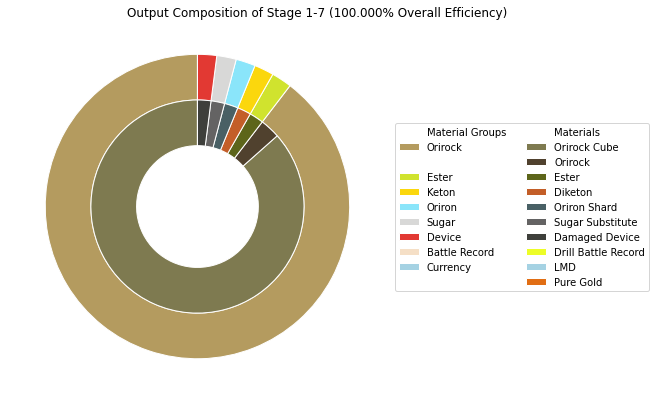

In [ ]:
# @title Stage Output Breakdown

import collections
import matplotlib.pyplot as plt

def stage_output_in_sanity(stage):
  """Computes the sanity values of a stage's outputs.

  Args:
    stage: Stage

  Returns:
    {Material: float}
  """
  activity = stage_to_activity[stage]
  output_to_sanity = {}

  for material in material_collection.get_all_materials():
    if activity.material_coefficients[material.numpy_id] > 0:
      output_to_sanity[material] = (
          planner.sanity_value(material.name) *
          activity.material_coefficients[material.numpy_id])

  return output_to_sanity

def sort_stage_output_by_group(output_to_sanity):
  """Sorts the stage's outputs by groups, arranged in decreasing sanity value.

  Args:
    output_to_sanity: {Material: float}
  
  Returns:
    [(str, float)], a sequence of group name and the group's total sanity value.
  """
  group_to_sanity = collections.defaultdict(float)
  for output in output_to_sanity:
    group_to_sanity[output.group] -= output_to_sanity[output]

  sanity_group_pairs = []
  for group in group_to_sanity:
    sanity_group_pairs.append((group_to_sanity[group], group))
  sanity_group_pairs.sort()
  return [(elem[1], -elem[0]) for elem in sanity_group_pairs]

def subsort_stage_output_within_group(output_to_sanity, group_sanity_pairs):
  """Sorts the stage's output within groups by decreasing sanity value.

  Args:
    output_to_sanity: {Material: float}
    group_sanity_pairs: [(str, float)], the output of sort_stage_output_by_group
  
  Returns:
    [(Material, float)], a sequence of material and the material's sanity value.
  """
  group_to_index = {}
  for i, group_sanity_pair in enumerate(group_sanity_pairs):
    group_to_index[group_sanity_pair[0]] = i
  
  group_index_sanity_material_triples = []
  for material in output_to_sanity:
    group_index_sanity_material_triples.append((
        group_to_index[material.group],
        -output_to_sanity[material],
        material
    ))
  group_index_sanity_material_triples.sort()
  return [(elem[2], -elem[1]) for elem in group_index_sanity_material_triples]

# @markdown Select a stage to analyze with the sanity values computed by the planner.
# @markdown You can select a stage that the planner did not consider, which may result in an efficiency score of over 100%.
# @markdown The outer ring of the chart signifies how much sanity value the stage outputs, in expectation, of each material group.
# @markdown The entire circle represents the entire sanity value output of the stage, which may not equal the sanity cost of the stage.
# @markdown The inner ring of the chart breaks down each material group into individual materials.
# @markdown The joint legend lists material groups / materials in counterclockwise order starting from 12 o'clock.
stage_to_analyze = 'main_01-07'  #@param {type:'string'}

stage = stage_collection.get_stage_with_stage_id(stage_to_analyze)
output_to_sanity = stage_output_in_sanity(stage)
group_sanity_pairs = sort_stage_output_by_group(output_to_sanity)
material_sanity_pairs = subsort_stage_output_within_group(output_to_sanity,
                                                          group_sanity_pairs)

outer_values = []
outer_colors = []
for group_sanity_pair in group_sanity_pairs:
  outer_values.append(group_sanity_pair[1])
  outer_colors.append(group_name_to_color[group_sanity_pair[0]])

inner_values = []
inner_labels = []
previous_outer_label = None
outer_labels = []
inner_colors = []
for material_sanity_pair in material_sanity_pairs:
  inner_values.append(material_sanity_pair[1])
  inner_labels.append(material_sanity_pair[0].name)
  inner_colors.append(material_name_to_color[material_sanity_pair[0].name])
  if material_sanity_pair[0].group == previous_outer_label:
    outer_labels.append('')
  else:
    outer_labels.append(material_sanity_pair[0].group)
    previous_outer_label = material_sanity_pair[0].group

fig = plt.figure(figsize=(7, 7))
fig.suptitle(
    'Output Composition of Stage {} ({:.3f}% Overall Efficiency)'.format(
        stage.name, sum(output_to_sanity.values()) / stage.sanity_cost * 100),
    x=0.75, y=0.9)

outer_pie_wedges, _ = plt.pie(outer_values, colors=outer_colors,
                              startangle=90, radius=1,
                              labeldistance=None,
                              wedgeprops = {'width': 0.3, 'edgecolor': 'w'})
inner_pie_wedges, _ = plt.pie(inner_values, colors=inner_colors,
                              startangle=90, radius=0.7,
                              labeldistance=None,
                              wedgeprops = {'width': 0.3, 'edgecolor': 'w'})
dummy, = plt.plot([0], marker='None', linestyle='None', label='dummy')

# Compute our complicated legend box.
padded_outer_pie = []
outer_pie_index = 0
for outer_label in outer_labels:
  if outer_label == '':
    padded_outer_pie.append(dummy)
  else:
    padded_outer_pie.append(outer_pie_wedges[outer_pie_index])
    outer_pie_index += 1
plt.legend([dummy] + padded_outer_pie + [dummy] + inner_pie_wedges,
           ['Material Groups'] + outer_labels + ['Materials'] + inner_labels,
           ncol=2, loc='center right', bbox_to_anchor=(1.7, 0.5))
plt.show()